In [1]:
from astropy.io import fits
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
np.seterr(divide='ignore', invalid='ignore');
plt.rcParams.update({'figure.max_open_warning': 0})
import scipy.stats as stats
import astropy.units as u
from astropy.table import Table, Column, MaskedColumn, join
from tqdm import tqdm
from bisect import bisect_left
c = 2.998e10
k = 1.38e-16
h = 6.626e-27
plt.rcParams.update({'font.size': 22})
halpha = 6564.61
hbeta = 4862.68
hgamma = 4341.68
hdelta = 4102.89
plt.rcParams['figure.figsize'] = [15, 10]
from IPython.display import Audio, display
def allDone():
    display(Audio(filename='beep.mp3', autoplay=True))
from scipy.interpolate import interp1d,InterpolatedUnivariateSpline
import lmfit

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
import emcee
import corner
import numdifftools
from scipy.ndimage import interpolation
from scipy.signal import medfilt
from scipy.interpolate import interp1d
from multiprocessing import Pool
import pickle

In [8]:
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize,scale,MinMaxScaler,StandardScaler
import multiprocessing

# Get Data Spectra

3723


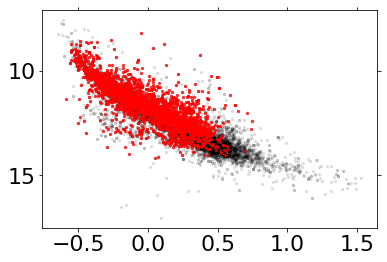

In [75]:
wdtable = Table.read('wdtable_sn.fits')

good = (
    (wdtable['subclass'] == 'WD')[:,0].data
)

print(len(wdtable[good]))
plt.scatter(wdtable['bp_rp'],wdtable['abs_g'],s = 5, alpha=0.1,color='k')
plt.scatter(wdtable[good]['bp_rp'],wdtable[good]['abs_g'],s = 5, alpha=0.7,color='r')
plt.gca().invert_yaxis()
wdtable = wdtable[good]

In [76]:
bgrid = np.linspace(np.min(wdtable['bp_rp']),np.max(wdtable['bp_rp']),50)
ggrid = np.linspace(np.min(wdtable['abs_g']),np.max(wdtable['abs_g']),50)
bint = bgrid[1]-bgrid[0]
gint = ggrid[1]-ggrid[0]

In [77]:
selections = [];
for i in tqdm(bgrid):
    for j in ggrid:
        square = (wdtable['bp_rp'] > i)*(wdtable['abs_g'] > j)*\
                (wdtable['bp_rp'] < i+bint)*(wdtable['abs_g'] < j+gint)
        if len(wdtable[square]) > 0:
            snmaxidx = np.argmax(wdtable[square]['S2N'])
            selections.append(wdtable[square][snmaxidx]['specnames'])


100%|██████████| 50/50 [01:15<00:00,  1.01it/s]

In [78]:
idxs = [];
for i in selections:
    idxs.append(np.argmax(wdtable['specnames'] == i))

In [79]:
goodtable = wdtable[idxs]
len(goodtable)

713

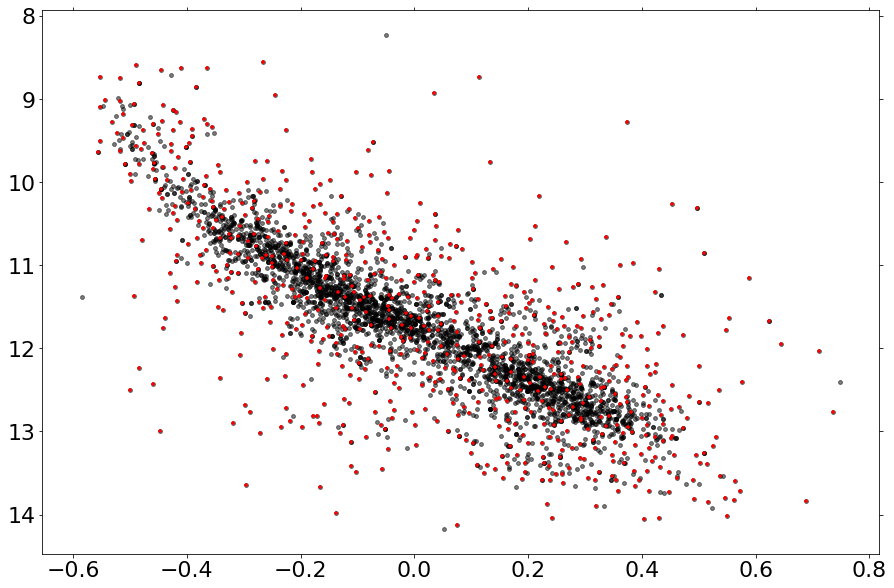

In [80]:
plt.figure(figsize=(15,10))
plt.scatter(wdtable['bp_rp'],wdtable['abs_g'],s=15,color='k',alpha=0.5)
plt.scatter(goodtable['bp_rp'],goodtable['abs_g'],s=15,color='r',marker='+')
plt.gca().invert_yaxis()

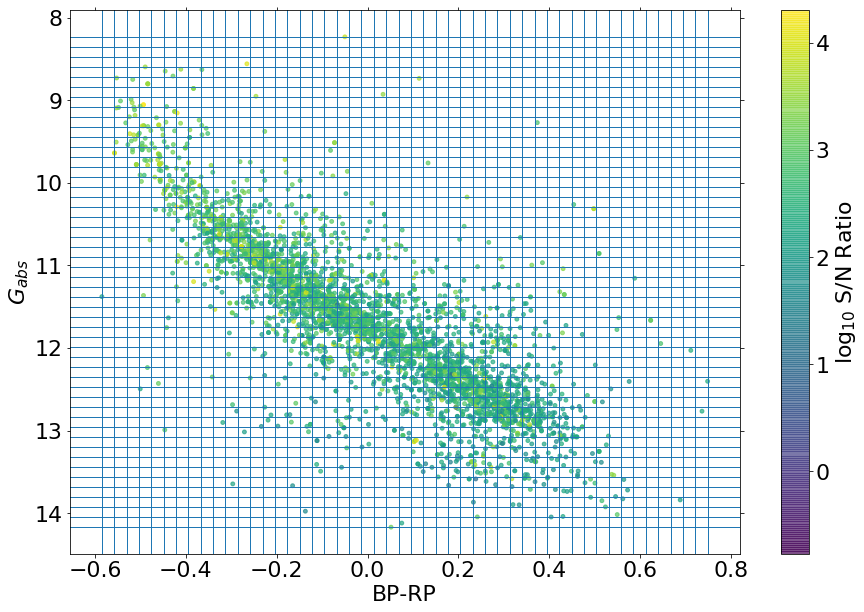

In [81]:
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

plt.figure(figsize=(15,10))

for i in range(len(bgrid)):
    plt.axvline(bgrid[i],linewidth=1)
    plt.axhline(ggrid[i],linewidth=1)

plt.scatter(wdtable['bp_rp'],wdtable['abs_g'],s=15,alpha=0.7,c=wdtable['S2N'])
cbar = plt.colorbar()

cbar.ax.set_ylabel('$\log_{10}$ S/N Ratio')
plt.gca().invert_yaxis()
plt.xlabel('BP-RP')
plt.ylabel('$G_{abs}$')
plt.rcParams.update({'font.size': 22})


In [82]:
bigtable = wdtable
wdtable = goodtable
TeffHs = [];
loggHs = [];
specnames = []
spectra = [];

# def rvcorr(spectrum):
#     lamgrid = np.arange(4000,8000)
#     coremask = (lamgrid == 6565)+(lamgrid == 4863)+(lamgrid == 4342)+(lamgrid == 4103)
#     coremask = coremask.astype(int)
#     trans = np.argmax(np.correlate(1-spectrum,coremask,mode='full'))-4000
#     if trans > 5:
#         trans = 5;
#     elif trans < 5:
#         trans = -5;
#     else:
#         ;
#     shiftedspec = interpolation.shift(spectrum,-trans,cval=1)
#     return shiftedspec

searchparameter = list(wdtable['specnames'])
bprps = [];
gs = [];
## Enter search parameter, if needed:
inputPath = "../scratch/spec/"

if os.path.exists(inputPath+".DS_Store"):
    os.remove(inputPath+"/.DS_Store")
    
filenames = [i+'.fits' for i in searchparameter]

from scipy.signal import medfilt
from scipy.interpolate import interp1d

len(filenames)

for specname in tqdm(filenames):
    f = fits.open(inputPath+specname)
    loglam = f[1].data['loglam']
    flux = f[1].data['flux']
    lam = 10**loglam
    lam = lam.astype(np.float64)
    flux = flux.astype(np.float64)
    lamgrid = np.arange(4000,8000)
    func = interp1d(lam,flux,kind='cubic',assume_sorted = False,fill_value='extrapolate')
    flux = func(lamgrid)
    spectra.append(flux)
    TeffHs.append(wdtable[wdtable['specnames']==specname[:-5]]['TeffH'][0])
    loggHs.append(wdtable[wdtable['specnames']==specname[:-5]]['loggH'][0])
    bprps.append(wdtable[wdtable['specnames']==specname[:-5]]['bp_rp'][0])
    gs.append(wdtable[wdtable['specnames']==specname[:-5]]['abs_g'][0])
    specnames.append(specname)
spectra = np.asarray(spectra)
TeffHs = np.asarray(TeffHs)
loggHs = np.asarray(loggHs)
bprps = np.asarray(bprps)
gs = np.asarray(gs)


 38%|███▊      | 273/713 [00:33<01:01,  7.12it/s]


 73%|███████▎  | 523/713 [01:05<00:31,  6.07it/s]


100%|██████████| 713/713 [01:39<00:00,  8.57it/s]

In [83]:
lam = np.arange(4000,8000)
lamgrid = lam
lines = ((lam > hbeta-300) & (lam < hbeta + 300)) | ((lam > halpha-400) & (lam < halpha + 400))\
        | ((lam > hgamma-400) & (lam < hgamma + 200))

mask = ~lines | ((lam > 4010) & (lam < 4050)) | ((lam > 4190) & (lam < 4230))
def quadratic(array,c1,c2,c3,c4):
    return c1 + c2*array + c3*array**2 + c4*array**3

In [84]:
normspec = [];

for i in tqdm(range(len(spectra))):
    p,cov = curve_fit(quadratic,lamgrid[mask],spectra[i][mask],p0=[-25,1e-2,1e-5,1e-10])
    contcorr = (spectra[i]/quadratic(lam,p[0],p[1],p[2],p[3]))
    skylinemask = (lamgrid > 5578.5 - 10)*(lamgrid < 5578.5 + 10) + (lamgrid > 5894.6 - 10)*(lamgrid < 5894.6 + 10)\
        + (lamgrid > 6301.7 - 10)*(lamgrid < 6301.7 + 10) + (lamgrid > 7246.0 - 10)*(lamgrid < 7246.0 + 10) + \
        (lamgrid > 5173 - 10)*(lamgrid < 5173 + 10)
    contcorr[skylinemask] = 1
    #contcorr = rvcorr(contcorr)
    #contcorr = np.log(contcorr)
    where = np.isnan(contcorr)
    contcorr[where] = 0
    normspec.append(contcorr[0:3000])
normspec = np.asarray(normspec)
len(normspec)


100%|██████████| 713/713 [00:01<00:00, 376.68it/s]

713

2.4817714575461522


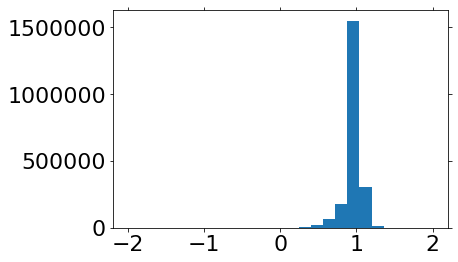

In [85]:
print(np.max(normspec))
plt.hist(np.ravel(normspec),bins=25,range = (-2,2));

In [86]:
where = (normspec > 2.5)+(normspec < -1)

In [87]:
normspec[where] = 1

2.4817714575461522


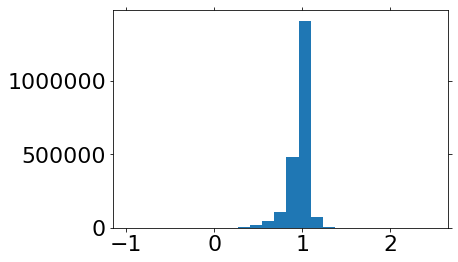

In [88]:
plt.hist(np.ravel(normspec),bins=25);
print(np.max(normspec))

# Train Generator

In [89]:
sc = StandardScaler()
msc = StandardScaler()

In [90]:
X = sc.fit_transform(np.stack((bprps,gs)).transpose())
t = msc.fit_transform(normspec)

In [91]:
#import keras
def generator():
    x = Input(shape=X[0].shape)
    y = Dense(25,activation='sigmoid')(x)
    y = Dropout(0.5)(y)
    y = Dense(25,activation='sigmoid')(y)
    y = Dropout(0.5)(y)
    out = Dense(t[0].shape[0],activation = 'linear')(y)
    
    model = Model(inputs = x, outputs = out)
    model.compile(optimizer = Adam(lr=0.001), loss = 'mse', \
                  metrics = ['mean_absolute_percentage_error'])
    return model
model = generator()
print(model.summary())
model.load_weights('ddriven_outliers.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 25)                75        
_________________________________________________________________
dropout_5 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 25)                650       
_________________________________________________________________
dropout_6 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 3000)              78000     
Total params: 78,725
Trainable params: 78,725
Non-trainable params: 0
_________________________________________________________________
None


In [96]:
epoch = 10000
batch = len(X)
history = [];
for i in tqdm(range(epoch)):
    h = model.fit(X,t,epochs=1,verbose=0,batch_size=batch)
    history.append(h.history['loss'][0])


  7%|▋         | 739/10000 [00:15<03:16, 47.03it/s]


 15%|█▍        | 1474/10000 [00:31<03:05, 45.89it/s]


 22%|██▏       | 2204/10000 [00:47<02:44, 47.30it/s]


 29%|██▉       | 2934/10000 [01:03<02:28, 47.55it/s]


 37%|███▋      | 3664/10000 [01:19<02:19, 45.45it/s]


 44%|████▍     | 4394/10000 [01:34<02:02, 45.92it/s]


 51%|█████     | 5124/10000 [01:50<01:43, 46.96it/s]


 59%|█████▊    | 5854/10000 [02:06<01:30, 46.03it/s]


 66%|██████▌   | 6584/10000 [02:22<01:12, 47.06it/s]


 73%|███████▎  | 7314/10000 [02:38<00:58, 46.08it/s]


 80%|████████  | 8044/10000 [02:53<00:42, 45.57it/s]


 88%|████████▊ | 8774/10000 [03:09<00:26, 46.64it/s]


 95%|█████████▌| 9504/10000 [03:25<00:10, 45.89it/s]


100%|██████████| 10000/10000 [03:36<00:00, 46.26it/s]

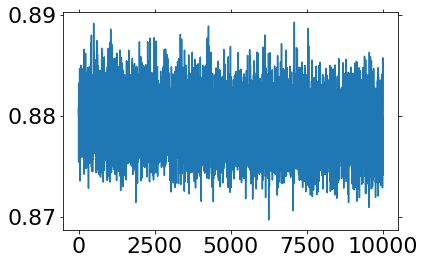

In [97]:
plt.plot((history))

### Evaluate BPRP Sensitivity

Text(0.5, 1.0, 'H-Beta Line')

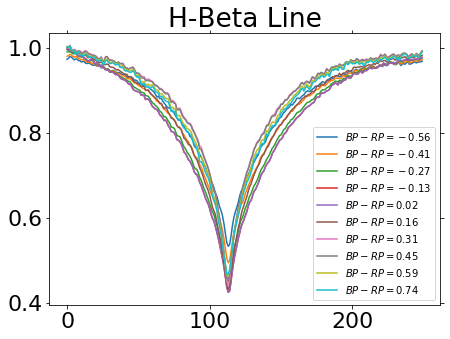

In [98]:
plt.figure(figsize=(7,5))
ts = np.linspace(min(bprps),max(bprps),10)
ls = np.linspace(np.mean(gs),np.mean(gs),10)
samples = sc.transform(np.stack((ts,ls)).transpose())
gens = msc.inverse_transform(model.predict(samples))
tscores = (ts - np.min(ts))/(np.max(ts) - np.min(ts))
for i in range(len(gens)):
    plt.plot(gens[i][750:1000],label='$BP-RP = %.2f$'%ts[i])
plt.legend(fontsize=10)
plt.title('H-Beta Line')

### Evaluate G_abs Sensitivity

Text(0.5, 1.0, 'H-Beta Line')

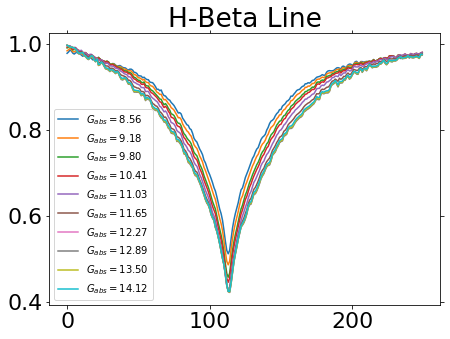

In [105]:
plt.figure(figsize=(7,5))
ts = np.linspace(np.mean(bprps),np.mean(bprps),10)
ls = np.linspace(min(gs),max(gs),10)
samples = sc.transform(np.stack((ts,ls)).transpose())
gens = msc.inverse_transform(model.predict(samples))
for i in range(len(gens)):
    plt.plot(gens[i][750:1000],label='$G_{abs} = %.2f$'%ls[i])

plt.legend(fontsize=10)
plt.title('H-Beta Line')

In [114]:
bigtable = Table.read('wdtable.fits')
searchparameter = list(bigtable['specnames'])

## Enter search parameter, if needed:
inputPath = "../scratch/spec/"

if os.path.exists(inputPath+".DS_Store"):
    os.remove(inputPath+"/.DS_Store")
    
filenames = [i+'.fits' for i in searchparameter]

from scipy.signal import medfilt
from scipy.interpolate import interp1d

len(filenames)


allspectra = [];
allspecnames = [];
for specname in tqdm(filenames):
    f = fits.open(inputPath+specname)
    loglam = f[1].data['loglam']
    flux = f[1].data['flux']
    lam = 10**loglam
    lam = lam.astype(np.float64)
    flux = flux.astype(np.float64)
    lamgrid = np.arange(4000,8000)
    func = interp1d(lam,flux,kind='cubic',assume_sorted = False,fill_value='extrapolate')
    flux = func(lamgrid)
    allspectra.append(flux)
    allspecnames.append(specname)
allspectra = np.asarray(allspectra)
allspecnames = np.asarray(allspecnames)



  0%|          | 0/11075 [00:00<?, ?it/s]

  0%|          | 4/11075 [00:00<05:00, 36.81it/s]

  0%|          | 7/11075 [00:00<05:35, 32.98it/s]

  0%|          | 15/11075 [00:00<04:41, 39.24it/s]

  0%|          | 19/11075 [00:00<08:24, 21.91it/s]

  0%|          | 22/11075 [00:00<08:32, 21.57it/s]

  0%|          | 25/11075 [00:01<13:17, 13.85it/s]

  0%|          | 28/11075 [00:01<12:07, 15.19it/s]

  0%|          | 30/11075 [00:01<13:26, 13.69it/s]

  0%|          | 32/11075 [00:01<12:29, 14.73it/s]

  0%|          | 34/11075 [00:01<11:48, 15.58it/s]

  0%|          | 38/11075 [00:01<09:49, 18.73it/s]

  0%|          | 42/11075 [00:02<08:26, 21.76it/s]

  0%|          | 45/11075 [00:02<08:21, 21.99it/s]

  0%|          | 49/11075 [00:02<07:33, 24.31it/s]

  0%|          | 54/11075 [00:02<06:55, 26.51it/s]

  1%|          | 57/11075 [00:02<08:11, 22.43it/s]

  1%|          | 60/11075 [00:02<07:54, 23.21it/s]

  1%|          | 63/11075 [00:02<08:13, 22.30it/s]

  1%|          | 66/1

  4%|▎         | 405/11075 [00:26<11:46, 15.09it/s]

  4%|▎         | 407/11075 [00:26<13:16, 13.39it/s]

  4%|▎         | 409/11075 [00:26<17:12, 10.33it/s]

  4%|▎         | 411/11075 [00:26<15:50, 11.22it/s]

  4%|▎         | 413/11075 [00:26<14:54, 11.92it/s]

  4%|▎         | 415/11075 [00:27<20:49,  8.53it/s]

  4%|▍         | 418/11075 [00:27<17:07, 10.37it/s]

  4%|▍         | 420/11075 [00:27<14:48, 11.99it/s]

  4%|▍         | 422/11075 [00:27<13:53, 12.77it/s]

  4%|▍         | 424/11075 [00:27<13:10, 13.47it/s]

  4%|▍         | 426/11075 [00:28<15:54, 11.16it/s]

  4%|▍         | 428/11075 [00:28<15:39, 11.33it/s]

  4%|▍         | 430/11075 [00:28<14:40, 12.09it/s]

  4%|▍         | 432/11075 [00:28<14:33, 12.18it/s]

  4%|▍         | 434/11075 [00:28<19:39,  9.02it/s]

  4%|▍         | 436/11075 [00:29<24:18,  7.30it/s]

  4%|▍         | 437/11075 [00:29<23:44,  7.47it/s]

  4%|▍         | 439/11075 [00:29<30:17,  5.85it/s]

  4%|▍         | 441/11075 [00:30<24:50,  7.13

  7%|▋         | 731/11075 [00:56<09:37, 17.91it/s]

  7%|▋         | 734/11075 [00:57<11:20, 15.19it/s]

  7%|▋         | 736/11075 [00:57<12:58, 13.28it/s]

  7%|▋         | 739/11075 [00:57<11:33, 14.90it/s]

  7%|▋         | 741/11075 [00:57<10:55, 15.77it/s]

  7%|▋         | 743/11075 [00:57<14:00, 12.29it/s]

  7%|▋         | 746/11075 [00:57<12:12, 14.10it/s]

  7%|▋         | 748/11075 [00:58<11:46, 14.62it/s]

  7%|▋         | 750/11075 [00:58<10:56, 15.73it/s]

  7%|▋         | 752/11075 [00:58<11:53, 14.46it/s]

  7%|▋         | 754/11075 [00:58<12:32, 13.72it/s]

  7%|▋         | 757/11075 [00:58<11:03, 15.55it/s]

  7%|▋         | 759/11075 [00:58<10:40, 16.12it/s]

  7%|▋         | 763/11075 [00:58<09:21, 18.37it/s]

  7%|▋         | 766/11075 [00:59<09:47, 17.56it/s]

  7%|▋         | 769/11075 [00:59<09:53, 17.38it/s]

  7%|▋         | 771/11075 [00:59<09:45, 17.59it/s]

  7%|▋         | 773/11075 [00:59<11:11, 15.34it/s]

  7%|▋         | 775/11075 [00:59<13:24, 12.81

  9%|▉         | 1051/11075 [01:25<58:45,  2.84it/s]

 10%|▉         | 1053/11075 [01:26<45:02,  3.71it/s]

 10%|▉         | 1056/11075 [01:26<40:19,  4.14it/s]

 10%|▉         | 1059/11075 [01:26<30:38,  5.45it/s]

 10%|▉         | 1061/11075 [01:27<30:49,  5.41it/s]

 10%|▉         | 1063/11075 [01:27<24:15,  6.88it/s]

 10%|▉         | 1066/11075 [01:27<19:18,  8.64it/s]

 10%|▉         | 1068/11075 [01:27<16:33, 10.07it/s]

 10%|▉         | 1070/11075 [01:27<15:30, 10.75it/s]

 10%|▉         | 1072/11075 [01:28<25:54,  6.43it/s]

 10%|▉         | 1075/11075 [01:28<20:17,  8.22it/s]

 10%|▉         | 1077/11075 [01:28<17:07,  9.73it/s]

 10%|▉         | 1079/11075 [01:28<14:46, 11.28it/s]

 10%|▉         | 1081/11075 [01:28<14:04, 11.83it/s]

 10%|▉         | 1085/11075 [01:28<11:36, 14.34it/s]

 10%|▉         | 1087/11075 [01:29<11:04, 15.02it/s]

 10%|▉         | 1091/11075 [01:29<09:24, 17.69it/s]

 10%|▉         | 1094/11075 [01:29<10:25, 15.96it/s]

 10%|▉         | 1096/11075 

 12%|█▏        | 1357/11075 [01:55<17:51,  9.07it/s]

 12%|█▏        | 1359/11075 [01:55<15:09, 10.68it/s]

 12%|█▏        | 1361/11075 [01:55<15:15, 10.61it/s]

 12%|█▏        | 1363/11075 [01:55<13:19, 12.15it/s]

 12%|█▏        | 1365/11075 [01:55<12:09, 13.31it/s]

 12%|█▏        | 1368/11075 [01:55<10:28, 15.45it/s]

 12%|█▏        | 1371/11075 [01:55<09:36, 16.85it/s]

 12%|█▏        | 1373/11075 [01:56<11:22, 14.21it/s]

 12%|█▏        | 1375/11075 [01:56<11:10, 14.47it/s]

 12%|█▏        | 1378/11075 [01:56<09:50, 16.43it/s]

 12%|█▏        | 1381/11075 [01:56<11:03, 14.62it/s]

 12%|█▏        | 1384/11075 [01:56<09:30, 16.98it/s]

 13%|█▎        | 1387/11075 [01:56<08:55, 18.08it/s]

 13%|█▎        | 1390/11075 [01:57<08:32, 18.90it/s]

 13%|█▎        | 1393/11075 [01:57<12:36, 12.79it/s]

 13%|█▎        | 1396/11075 [01:57<10:43, 15.04it/s]

 13%|█▎        | 1398/11075 [01:57<12:29, 12.90it/s]

 13%|█▎        | 1400/11075 [01:57<12:32, 12.85it/s]

 13%|█▎        | 1402/11075 

 15%|█▌        | 1666/11075 [02:21<08:55, 17.57it/s]

 15%|█▌        | 1669/11075 [02:21<11:26, 13.71it/s]

 15%|█▌        | 1671/11075 [02:21<13:10, 11.90it/s]

 15%|█▌        | 1674/11075 [02:22<11:22, 13.77it/s]

 15%|█▌        | 1678/11075 [02:22<09:32, 16.43it/s]

 15%|█▌        | 1681/11075 [02:22<09:03, 17.29it/s]

 15%|█▌        | 1684/11075 [02:22<08:17, 18.86it/s]

 15%|█▌        | 1687/11075 [02:22<09:10, 17.07it/s]

 15%|█▌        | 1689/11075 [02:22<11:27, 13.64it/s]

 15%|█▌        | 1691/11075 [02:22<11:22, 13.75it/s]

 15%|█▌        | 1694/11075 [02:23<10:06, 15.46it/s]

 15%|█▌        | 1696/11075 [02:23<09:29, 16.46it/s]

 15%|█▌        | 1698/11075 [02:23<09:27, 16.54it/s]

 15%|█▌        | 1701/11075 [02:23<09:26, 16.53it/s]

 15%|█▌        | 1703/11075 [02:23<09:52, 15.82it/s]

 15%|█▌        | 1705/11075 [02:23<09:34, 16.31it/s]

 15%|█▌        | 1708/11075 [02:23<08:23, 18.62it/s]

 15%|█▌        | 1712/11075 [02:24<08:05, 19.29it/s]

 15%|█▌        | 1715/11075 

 18%|█▊        | 1980/11075 [02:48<10:05, 15.02it/s]

 18%|█▊        | 1982/11075 [02:48<09:58, 15.20it/s]

 18%|█▊        | 1984/11075 [02:48<09:56, 15.25it/s]

 18%|█▊        | 1986/11075 [02:48<09:56, 15.23it/s]

 18%|█▊        | 1988/11075 [02:49<13:03, 11.60it/s]

 18%|█▊        | 1990/11075 [02:49<17:16,  8.76it/s]

 18%|█▊        | 1993/11075 [02:49<13:50, 10.94it/s]

 18%|█▊        | 1996/11075 [02:49<12:34, 12.03it/s]

 18%|█▊        | 1998/11075 [02:49<11:42, 12.93it/s]

 18%|█▊        | 2000/11075 [02:49<11:49, 12.80it/s]

 18%|█▊        | 2003/11075 [02:50<13:09, 11.50it/s]

 18%|█▊        | 2005/11075 [02:50<13:22, 11.30it/s]

 18%|█▊        | 2008/11075 [02:50<11:19, 13.33it/s]

 18%|█▊        | 2010/11075 [02:50<10:37, 14.21it/s]

 18%|█▊        | 2012/11075 [02:51<16:16,  9.28it/s]

 18%|█▊        | 2015/11075 [02:51<13:25, 11.25it/s]

 18%|█▊        | 2017/11075 [02:51<14:40, 10.29it/s]

 18%|█▊        | 2019/11075 [02:51<13:46, 10.96it/s]

 18%|█▊        | 2022/11075 

 21%|██        | 2290/11075 [03:14<13:57, 10.49it/s]

 21%|██        | 2292/11075 [03:14<19:39,  7.45it/s]

 21%|██        | 2294/11075 [03:14<16:43,  8.75it/s]

 21%|██        | 2297/11075 [03:15<13:40, 10.69it/s]

 21%|██        | 2300/11075 [03:15<11:39, 12.54it/s]

 21%|██        | 2302/11075 [03:15<12:27, 11.73it/s]

 21%|██        | 2305/11075 [03:15<10:20, 14.13it/s]

 21%|██        | 2307/11075 [03:15<10:29, 13.92it/s]

 21%|██        | 2309/11075 [03:15<10:03, 14.53it/s]

 21%|██        | 2312/11075 [03:15<08:47, 16.63it/s]

 21%|██        | 2314/11075 [03:16<09:54, 14.74it/s]

 21%|██        | 2316/11075 [03:16<13:33, 10.77it/s]

 21%|██        | 2318/11075 [03:16<14:50,  9.84it/s]

 21%|██        | 2320/11075 [03:16<14:22, 10.15it/s]

 21%|██        | 2322/11075 [03:17<13:15, 11.01it/s]

 21%|██        | 2324/11075 [03:17<12:09, 12.00it/s]

 21%|██        | 2326/11075 [03:17<13:03, 11.17it/s]

 21%|██        | 2328/11075 [03:17<13:33, 10.75it/s]

 21%|██        | 2330/11075 

 23%|██▎       | 2598/11075 [03:42<09:28, 14.90it/s]

 23%|██▎       | 2600/11075 [03:42<09:09, 15.42it/s]

 24%|██▎       | 2603/11075 [03:42<10:28, 13.48it/s]

 24%|██▎       | 2606/11075 [03:43<16:54,  8.35it/s]

 24%|██▎       | 2608/11075 [03:43<14:09,  9.97it/s]

 24%|██▎       | 2610/11075 [03:43<15:59,  8.82it/s]

 24%|██▎       | 2612/11075 [03:44<13:18, 10.60it/s]

 24%|██▎       | 2614/11075 [03:44<11:43, 12.03it/s]

 24%|██▎       | 2616/11075 [03:44<12:08, 11.61it/s]

 24%|██▎       | 2618/11075 [03:44<13:52, 10.16it/s]

 24%|██▎       | 2620/11075 [03:44<12:24, 11.36it/s]

 24%|██▎       | 2622/11075 [03:44<11:38, 12.10it/s]

 24%|██▎       | 2624/11075 [03:45<21:49,  6.45it/s]

 24%|██▎       | 2629/11075 [03:45<16:19,  8.63it/s]

 24%|██▍       | 2631/11075 [03:45<14:06,  9.98it/s]

 24%|██▍       | 2635/11075 [03:45<11:28, 12.26it/s]

 24%|██▍       | 2638/11075 [03:46<10:12, 13.78it/s]

 24%|██▍       | 2641/11075 [03:46<10:00, 14.04it/s]

 24%|██▍       | 2643/11075 

 26%|██▋       | 2911/11075 [04:08<08:05, 16.80it/s]

 26%|██▋       | 2914/11075 [04:09<07:40, 17.72it/s]

 26%|██▋       | 2917/11075 [04:09<07:02, 19.33it/s]

 26%|██▋       | 2920/11075 [04:09<06:39, 20.41it/s]

 26%|██▋       | 2923/11075 [04:09<09:16, 14.64it/s]

 26%|██▋       | 2925/11075 [04:09<08:45, 15.50it/s]

 26%|██▋       | 2927/11075 [04:10<12:09, 11.16it/s]

 26%|██▋       | 2929/11075 [04:10<15:35,  8.70it/s]

 26%|██▋       | 2932/11075 [04:10<12:25, 10.93it/s]

 26%|██▋       | 2934/11075 [04:10<11:00, 12.32it/s]

 27%|██▋       | 2937/11075 [04:10<10:38, 12.74it/s]

 27%|██▋       | 2939/11075 [04:11<09:31, 14.24it/s]

 27%|██▋       | 2941/11075 [04:11<15:59,  8.48it/s]

 27%|██▋       | 2943/11075 [04:11<13:20, 10.16it/s]

 27%|██▋       | 2945/11075 [04:11<11:54, 11.38it/s]

 27%|██▋       | 2948/11075 [04:11<10:15, 13.21it/s]

 27%|██▋       | 2950/11075 [04:12<13:23, 10.11it/s]

 27%|██▋       | 2952/11075 [04:12<12:05, 11.20it/s]

 27%|██▋       | 2954/11075 

 29%|██▉       | 3223/11075 [04:34<11:27, 11.43it/s]

 29%|██▉       | 3225/11075 [04:34<11:13, 11.66it/s]

 29%|██▉       | 3227/11075 [04:34<09:54, 13.21it/s]

 29%|██▉       | 3229/11075 [04:34<09:02, 14.46it/s]

 29%|██▉       | 3231/11075 [04:35<17:52,  7.32it/s]

 29%|██▉       | 3234/11075 [04:35<14:58,  8.72it/s]

 29%|██▉       | 3236/11075 [04:35<18:53,  6.92it/s]

 29%|██▉       | 3239/11075 [04:36<14:40,  8.89it/s]

 29%|██▉       | 3241/11075 [04:36<18:45,  6.96it/s]

 29%|██▉       | 3243/11075 [04:36<15:31,  8.41it/s]

 29%|██▉       | 3245/11075 [04:36<14:16,  9.14it/s]

 29%|██▉       | 3247/11075 [04:37<15:43,  8.30it/s]

 29%|██▉       | 3249/11075 [04:37<13:35,  9.60it/s]

 29%|██▉       | 3251/11075 [04:37<11:30, 11.34it/s]

 29%|██▉       | 3253/11075 [04:37<11:07, 11.73it/s]

 29%|██▉       | 3255/11075 [04:37<10:47, 12.08it/s]

 29%|██▉       | 3257/11075 [04:37<09:43, 13.41it/s]

 29%|██▉       | 3259/11075 [04:37<09:25, 13.81it/s]

 29%|██▉       | 3261/11075 

 32%|███▏      | 3545/11075 [05:01<13:21,  9.39it/s]

 32%|███▏      | 3548/11075 [05:02<15:17,  8.21it/s]

 32%|███▏      | 3551/11075 [05:02<12:37,  9.94it/s]

 32%|███▏      | 3553/11075 [05:02<10:56, 11.45it/s]

 32%|███▏      | 3555/11075 [05:02<11:54, 10.53it/s]

 32%|███▏      | 3558/11075 [05:02<10:56, 11.45it/s]

 32%|███▏      | 3561/11075 [05:03<12:19, 10.16it/s]

 32%|███▏      | 3563/11075 [05:03<10:34, 11.84it/s]

 32%|███▏      | 3565/11075 [05:03<14:45,  8.48it/s]

 32%|███▏      | 3567/11075 [05:04<16:36,  7.53it/s]

 32%|███▏      | 3568/11075 [05:04<20:39,  6.06it/s]

 32%|███▏      | 3570/11075 [05:04<19:37,  6.37it/s]

 32%|███▏      | 3572/11075 [05:04<16:09,  7.74it/s]

 32%|███▏      | 3574/11075 [05:04<16:41,  7.49it/s]

 32%|███▏      | 3576/11075 [05:05<14:20,  8.71it/s]

 32%|███▏      | 3579/11075 [05:05<11:40, 10.69it/s]

 32%|███▏      | 3581/11075 [05:05<10:51, 11.50it/s]

 32%|███▏      | 3584/11075 [05:05<09:22, 13.33it/s]

 32%|███▏      | 3586/11075 

 35%|███▍      | 3855/11075 [05:27<15:41,  7.67it/s]

 35%|███▍      | 3857/11075 [05:27<16:53,  7.12it/s]

 35%|███▍      | 3860/11075 [05:27<13:11,  9.12it/s]

 35%|███▍      | 3862/11075 [05:27<11:41, 10.28it/s]

 35%|███▍      | 3864/11075 [05:27<11:21, 10.58it/s]

 35%|███▍      | 3866/11075 [05:28<10:35, 11.34it/s]

 35%|███▍      | 3868/11075 [05:28<09:27, 12.71it/s]

 35%|███▍      | 3871/11075 [05:28<08:04, 14.87it/s]

 35%|███▍      | 3873/11075 [05:28<08:18, 14.45it/s]

 35%|███▍      | 3875/11075 [05:28<08:24, 14.28it/s]

 35%|███▌      | 3877/11075 [05:28<13:19,  9.00it/s]

 35%|███▌      | 3882/11075 [05:29<10:13, 11.72it/s]

 35%|███▌      | 3885/11075 [05:29<10:42, 11.19it/s]

 35%|███▌      | 3887/11075 [05:29<12:04,  9.92it/s]

 35%|███▌      | 3889/11075 [05:29<12:13,  9.80it/s]

 35%|███▌      | 3892/11075 [05:30<10:38, 11.25it/s]

 35%|███▌      | 3894/11075 [05:30<15:26,  7.75it/s]

 35%|███▌      | 3896/11075 [05:30<13:03,  9.16it/s]

 35%|███▌      | 3898/11075 

 38%|███▊      | 4181/11075 [05:56<09:16, 12.39it/s]

 38%|███▊      | 4184/11075 [05:56<08:16, 13.89it/s]

 38%|███▊      | 4186/11075 [05:56<07:52, 14.59it/s]

 38%|███▊      | 4188/11075 [05:57<12:40,  9.06it/s]

 38%|███▊      | 4190/11075 [05:57<13:42,  8.37it/s]

 38%|███▊      | 4192/11075 [05:57<12:36,  9.10it/s]

 38%|███▊      | 4194/11075 [05:57<13:04,  8.77it/s]

 38%|███▊      | 4196/11075 [05:57<12:21,  9.28it/s]

 38%|███▊      | 4198/11075 [05:58<11:22, 10.08it/s]

 38%|███▊      | 4200/11075 [05:58<10:48, 10.61it/s]

 38%|███▊      | 4202/11075 [05:58<09:50, 11.64it/s]

 38%|███▊      | 4204/11075 [05:58<08:56, 12.80it/s]

 38%|███▊      | 4209/11075 [05:58<07:19, 15.63it/s]

 38%|███▊      | 4212/11075 [05:58<07:50, 14.59it/s]

 38%|███▊      | 4214/11075 [05:59<07:56, 14.39it/s]

 38%|███▊      | 4217/11075 [05:59<07:25, 15.40it/s]

 38%|███▊      | 4219/11075 [05:59<07:14, 15.80it/s]

 38%|███▊      | 4222/11075 [05:59<06:34, 17.36it/s]

 38%|███▊      | 4224/11075 

 41%|████      | 4494/11075 [06:23<22:17,  4.92it/s]

 41%|████      | 4496/11075 [06:23<18:16,  6.00it/s]

 41%|████      | 4499/11075 [06:24<14:34,  7.52it/s]

 41%|████      | 4501/11075 [06:24<12:15,  8.93it/s]

 41%|████      | 4503/11075 [06:24<10:42, 10.23it/s]

 41%|████      | 4506/11075 [06:24<08:35, 12.73it/s]

 41%|████      | 4508/11075 [06:24<08:30, 12.86it/s]

 41%|████      | 4510/11075 [06:24<08:33, 12.78it/s]

 41%|████      | 4512/11075 [06:25<17:17,  6.33it/s]

 41%|████      | 4515/11075 [06:25<13:15,  8.25it/s]

 41%|████      | 4517/11075 [06:26<17:28,  6.26it/s]

 41%|████      | 4519/11075 [06:26<15:11,  7.19it/s]

 41%|████      | 4521/11075 [06:26<19:34,  5.58it/s]

 41%|████      | 4523/11075 [06:26<16:08,  6.76it/s]

 41%|████      | 4525/11075 [06:27<13:18,  8.20it/s]

 41%|████      | 4527/11075 [06:27<11:31,  9.47it/s]

 41%|████      | 4529/11075 [06:27<10:17, 10.60it/s]

 41%|████      | 4531/11075 [06:27<09:01, 12.09it/s]

 41%|████      | 4533/11075 

 44%|████▎     | 4822/11075 [06:48<07:11, 14.49it/s]

 44%|████▎     | 4825/11075 [06:48<06:20, 16.41it/s]

 44%|████▎     | 4828/11075 [06:48<07:02, 14.78it/s]

 44%|████▎     | 4830/11075 [06:48<06:31, 15.94it/s]

 44%|████▎     | 4832/11075 [06:49<06:22, 16.33it/s]

 44%|████▎     | 4834/11075 [06:49<08:40, 11.99it/s]

 44%|████▎     | 4836/11075 [06:49<07:43, 13.47it/s]

 44%|████▎     | 4838/11075 [06:49<07:08, 14.57it/s]

 44%|████▎     | 4840/11075 [06:49<07:44, 13.42it/s]

 44%|████▎     | 4842/11075 [06:49<09:00, 11.54it/s]

 44%|████▎     | 4845/11075 [06:50<08:12, 12.65it/s]

 44%|████▍     | 4847/11075 [06:50<07:50, 13.23it/s]

 44%|████▍     | 4849/11075 [06:50<07:22, 14.08it/s]

 44%|████▍     | 4851/11075 [06:50<07:20, 14.13it/s]

 44%|████▍     | 4855/11075 [06:50<05:59, 17.29it/s]

 44%|████▍     | 4858/11075 [06:50<05:47, 17.87it/s]

 44%|████▍     | 4861/11075 [06:50<05:10, 20.03it/s]

 44%|████▍     | 4864/11075 [06:50<04:46, 21.68it/s]

 44%|████▍     | 4868/11075 

 47%|████▋     | 5156/11075 [07:16<07:13, 13.65it/s]

 47%|████▋     | 5159/11075 [07:16<07:26, 13.25it/s]

 47%|████▋     | 5161/11075 [07:17<09:50, 10.02it/s]

 47%|████▋     | 5163/11075 [07:17<08:49, 11.16it/s]

 47%|████▋     | 5165/11075 [07:17<08:38, 11.40it/s]

 47%|████▋     | 5167/11075 [07:17<08:50, 11.14it/s]

 47%|████▋     | 5169/11075 [07:17<08:06, 12.13it/s]

 47%|████▋     | 5171/11075 [07:17<07:35, 12.97it/s]

 47%|████▋     | 5173/11075 [07:18<07:02, 13.98it/s]

 47%|████▋     | 5176/11075 [07:18<07:04, 13.90it/s]

 47%|████▋     | 5178/11075 [07:18<10:39,  9.22it/s]

 47%|████▋     | 5180/11075 [07:18<09:10, 10.70it/s]

 47%|████▋     | 5182/11075 [07:19<11:08,  8.81it/s]

 47%|████▋     | 5184/11075 [07:19<09:29, 10.35it/s]

 47%|████▋     | 5186/11075 [07:19<09:34, 10.25it/s]

 47%|████▋     | 5190/11075 [07:19<07:53, 12.44it/s]

 47%|████▋     | 5192/11075 [07:19<09:27, 10.37it/s]

 47%|████▋     | 5194/11075 [07:19<08:14, 11.89it/s]

 47%|████▋     | 5196/11075 

 49%|████▉     | 5461/11075 [07:41<06:59, 13.40it/s]

 49%|████▉     | 5463/11075 [07:41<08:55, 10.48it/s]

 49%|████▉     | 5465/11075 [07:41<08:00, 11.67it/s]

 49%|████▉     | 5467/11075 [07:41<07:19, 12.75it/s]

 49%|████▉     | 5469/11075 [07:41<07:16, 12.83it/s]

 49%|████▉     | 5471/11075 [07:41<06:31, 14.33it/s]

 49%|████▉     | 5473/11075 [07:41<06:10, 15.12it/s]

 49%|████▉     | 5475/11075 [07:42<06:12, 15.03it/s]

 49%|████▉     | 5477/11075 [07:42<06:30, 14.34it/s]

 49%|████▉     | 5479/11075 [07:42<11:57,  7.80it/s]

 49%|████▉     | 5481/11075 [07:43<13:40,  6.82it/s]

 50%|████▉     | 5483/11075 [07:43<11:05,  8.40it/s]

 50%|████▉     | 5486/11075 [07:43<09:05, 10.24it/s]

 50%|████▉     | 5488/11075 [07:43<07:53, 11.79it/s]

 50%|████▉     | 5491/11075 [07:43<06:31, 14.25it/s]

 50%|████▉     | 5493/11075 [07:44<09:34,  9.72it/s]

 50%|████▉     | 5495/11075 [07:44<08:25, 11.04it/s]

 50%|████▉     | 5497/11075 [07:44<09:17, 10.00it/s]

 50%|████▉     | 5500/11075 

 52%|█████▏    | 5775/11075 [08:07<06:03, 14.58it/s]

 52%|█████▏    | 5777/11075 [08:07<06:28, 13.65it/s]

 52%|█████▏    | 5779/11075 [08:08<08:08, 10.83it/s]

 52%|█████▏    | 5782/11075 [08:08<06:47, 13.00it/s]

 52%|█████▏    | 5784/11075 [08:08<06:22, 13.84it/s]

 52%|█████▏    | 5786/11075 [08:08<05:53, 14.96it/s]

 52%|█████▏    | 5788/11075 [08:08<05:56, 14.82it/s]

 52%|█████▏    | 5790/11075 [08:08<05:47, 15.20it/s]

 52%|█████▏    | 5792/11075 [08:08<05:29, 16.03it/s]

 52%|█████▏    | 5794/11075 [08:08<05:28, 16.06it/s]

 52%|█████▏    | 5797/11075 [08:08<04:44, 18.56it/s]

 52%|█████▏    | 5800/11075 [08:09<04:17, 20.52it/s]

 52%|█████▏    | 5803/11075 [08:09<04:20, 20.22it/s]

 52%|█████▏    | 5806/11075 [08:09<04:28, 19.60it/s]

 52%|█████▏    | 5809/11075 [08:09<04:28, 19.63it/s]

 52%|█████▏    | 5813/11075 [08:09<04:23, 19.96it/s]

 53%|█████▎    | 5816/11075 [08:10<07:10, 12.20it/s]

 53%|█████▎    | 5819/11075 [08:10<06:14, 14.03it/s]

 53%|█████▎    | 5821/11075 

 55%|█████▌    | 6113/11075 [08:32<06:51, 12.05it/s]

 55%|█████▌    | 6116/11075 [08:32<06:02, 13.69it/s]

 55%|█████▌    | 6118/11075 [08:33<06:14, 13.22it/s]

 55%|█████▌    | 6120/11075 [08:33<07:09, 11.54it/s]

 55%|█████▌    | 6122/11075 [08:33<06:47, 12.16it/s]

 55%|█████▌    | 6126/11075 [08:33<05:29, 15.04it/s]

 55%|█████▌    | 6129/11075 [08:33<04:55, 16.76it/s]

 55%|█████▌    | 6132/11075 [08:33<04:34, 17.99it/s]

 55%|█████▌    | 6135/11075 [08:34<05:59, 13.74it/s]

 55%|█████▌    | 6137/11075 [08:34<05:30, 14.94it/s]

 55%|█████▌    | 6139/11075 [08:34<06:20, 12.97it/s]

 55%|█████▌    | 6143/11075 [08:34<05:16, 15.56it/s]

 56%|█████▌    | 6147/11075 [08:34<04:31, 18.18it/s]

 56%|█████▌    | 6150/11075 [08:34<04:24, 18.61it/s]

 56%|█████▌    | 6153/11075 [08:35<08:56,  9.18it/s]

 56%|█████▌    | 6156/11075 [08:35<07:17, 11.23it/s]

 56%|█████▌    | 6158/11075 [08:35<06:37, 12.38it/s]

 56%|█████▌    | 6160/11075 [08:36<08:35,  9.54it/s]

 56%|█████▌    | 6163/11075 

 58%|█████▊    | 6435/11075 [08:58<05:50, 13.22it/s]

 58%|█████▊    | 6438/11075 [08:58<05:24, 14.30it/s]

 58%|█████▊    | 6440/11075 [08:58<05:33, 13.91it/s]

 58%|█████▊    | 6443/11075 [08:59<05:42, 13.54it/s]

 58%|█████▊    | 6445/11075 [08:59<06:01, 12.82it/s]

 58%|█████▊    | 6447/11075 [08:59<05:30, 13.99it/s]

 58%|█████▊    | 6450/11075 [08:59<05:10, 14.90it/s]

 58%|█████▊    | 6453/11075 [08:59<04:26, 17.36it/s]

 58%|█████▊    | 6456/11075 [08:59<04:10, 18.41it/s]

 58%|█████▊    | 6460/11075 [08:59<03:45, 20.42it/s]

 58%|█████▊    | 6463/11075 [09:00<03:37, 21.23it/s]

 58%|█████▊    | 6466/11075 [09:00<04:41, 16.37it/s]

 58%|█████▊    | 6468/11075 [09:00<04:26, 17.26it/s]

 58%|█████▊    | 6470/11075 [09:00<05:02, 15.23it/s]

 58%|█████▊    | 6473/11075 [09:00<04:31, 16.96it/s]

 58%|█████▊    | 6475/11075 [09:00<04:21, 17.62it/s]

 58%|█████▊    | 6478/11075 [09:00<04:08, 18.52it/s]

 59%|█████▊    | 6481/11075 [09:01<04:00, 19.12it/s]

 59%|█████▊    | 6483/11075 

 61%|██████    | 6780/11075 [09:24<05:24, 13.25it/s]

 61%|██████    | 6782/11075 [09:24<05:31, 12.95it/s]

 61%|██████▏   | 6785/11075 [09:24<04:58, 14.39it/s]

 61%|██████▏   | 6788/11075 [09:25<05:19, 13.41it/s]

 61%|██████▏   | 6790/11075 [09:25<04:56, 14.46it/s]

 61%|██████▏   | 6793/11075 [09:25<04:15, 16.76it/s]

 61%|██████▏   | 6795/11075 [09:25<04:48, 14.82it/s]

 61%|██████▏   | 6797/11075 [09:26<09:03,  7.88it/s]

 61%|██████▏   | 6799/11075 [09:26<07:26,  9.59it/s]

 61%|██████▏   | 6801/11075 [09:26<06:30, 10.94it/s]

 61%|██████▏   | 6804/11075 [09:26<05:31, 12.87it/s]

 61%|██████▏   | 6806/11075 [09:26<05:35, 12.74it/s]

 61%|██████▏   | 6808/11075 [09:26<05:03, 14.04it/s]

 61%|██████▏   | 6810/11075 [09:26<04:43, 15.04it/s]

 62%|██████▏   | 6812/11075 [09:26<05:25, 13.10it/s]

 62%|██████▏   | 6815/11075 [09:27<04:58, 14.29it/s]

 62%|██████▏   | 6817/11075 [09:27<04:52, 14.57it/s]

 62%|██████▏   | 6819/11075 [09:27<05:10, 13.73it/s]

 62%|██████▏   | 6821/11075 

 64%|██████▍   | 7101/11075 [09:51<05:15, 12.60it/s]

 64%|██████▍   | 7103/11075 [09:51<05:41, 11.64it/s]

 64%|██████▍   | 7105/11075 [09:51<04:59, 13.26it/s]

 64%|██████▍   | 7108/11075 [09:52<05:40, 11.65it/s]

 64%|██████▍   | 7112/11075 [09:52<04:28, 14.77it/s]

 64%|██████▍   | 7115/11075 [09:52<04:24, 14.99it/s]

 64%|██████▍   | 7117/11075 [09:52<04:38, 14.22it/s]

 64%|██████▍   | 7119/11075 [09:52<05:19, 12.39it/s]

 64%|██████▍   | 7121/11075 [09:53<04:47, 13.73it/s]

 64%|██████▍   | 7124/11075 [09:53<04:40, 14.11it/s]

 64%|██████▍   | 7128/11075 [09:53<04:11, 15.69it/s]

 64%|██████▍   | 7130/11075 [09:53<06:22, 10.31it/s]

 64%|██████▍   | 7132/11075 [09:53<05:55, 11.10it/s]

 64%|██████▍   | 7134/11075 [09:55<16:42,  3.93it/s]

 64%|██████▍   | 7138/11075 [09:55<14:29,  4.53it/s]

 64%|██████▍   | 7140/11075 [09:55<11:17,  5.81it/s]

 64%|██████▍   | 7142/11075 [09:56<09:00,  7.28it/s]

 65%|██████▍   | 7144/11075 [09:56<09:03,  7.23it/s]

 65%|██████▍   | 7147/11075 

 67%|██████▋   | 7421/11075 [10:20<04:10, 14.59it/s]

 67%|██████▋   | 7423/11075 [10:20<04:01, 15.14it/s]

 67%|██████▋   | 7426/11075 [10:20<03:42, 16.38it/s]

 67%|██████▋   | 7428/11075 [10:20<04:03, 15.00it/s]

 67%|██████▋   | 7430/11075 [10:21<03:53, 15.58it/s]

 67%|██████▋   | 7433/11075 [10:21<03:30, 17.26it/s]

 67%|██████▋   | 7435/11075 [10:21<03:30, 17.29it/s]

 67%|██████▋   | 7438/11075 [10:21<04:25, 13.69it/s]

 67%|██████▋   | 7441/11075 [10:21<03:51, 15.69it/s]

 67%|██████▋   | 7444/11075 [10:21<03:25, 17.70it/s]

 67%|██████▋   | 7447/11075 [10:22<03:40, 16.43it/s]

 67%|██████▋   | 7451/11075 [10:22<03:13, 18.74it/s]

 67%|██████▋   | 7454/11075 [10:22<03:34, 16.86it/s]

 67%|██████▋   | 7456/11075 [10:22<03:58, 15.18it/s]

 67%|██████▋   | 7458/11075 [10:22<04:19, 13.94it/s]

 67%|██████▋   | 7460/11075 [10:22<04:10, 14.40it/s]

 67%|██████▋   | 7462/11075 [10:23<04:04, 14.78it/s]

 67%|██████▋   | 7465/11075 [10:23<03:29, 17.24it/s]

 67%|██████▋   | 7467/11075 

 70%|███████   | 7758/11075 [10:45<06:16,  8.82it/s]

 70%|███████   | 7760/11075 [10:45<06:05,  9.08it/s]

 70%|███████   | 7762/11075 [10:45<05:35,  9.86it/s]

 70%|███████   | 7765/11075 [10:45<04:40, 11.78it/s]

 70%|███████   | 7767/11075 [10:45<04:24, 12.50it/s]

 70%|███████   | 7769/11075 [10:45<04:03, 13.56it/s]

 70%|███████   | 7771/11075 [10:46<03:59, 13.79it/s]

 70%|███████   | 7773/11075 [10:46<04:42, 11.68it/s]

 70%|███████   | 7776/11075 [10:46<05:24, 10.18it/s]

 70%|███████   | 7778/11075 [10:47<06:02,  9.10it/s]

 70%|███████   | 7781/11075 [10:47<04:57, 11.09it/s]

 70%|███████   | 7783/11075 [10:47<05:44,  9.57it/s]

 70%|███████   | 7785/11075 [10:47<04:55, 11.15it/s]

 70%|███████   | 7787/11075 [10:47<04:54, 11.15it/s]

 70%|███████   | 7789/11075 [10:47<04:26, 12.31it/s]

 70%|███████   | 7791/11075 [10:47<04:09, 13.14it/s]

 70%|███████   | 7793/11075 [10:48<04:35, 11.89it/s]

 70%|███████   | 7796/11075 [10:48<03:50, 14.25it/s]

 70%|███████   | 7798/11075 

 73%|███████▎  | 8082/11075 [11:19<10:02,  4.97it/s]

 73%|███████▎  | 8084/11075 [11:19<10:22,  4.80it/s]

 73%|███████▎  | 8086/11075 [11:20<08:25,  5.91it/s]

 73%|███████▎  | 8088/11075 [11:20<06:46,  7.35it/s]

 73%|███████▎  | 8090/11075 [11:20<05:30,  9.03it/s]

 73%|███████▎  | 8092/11075 [11:20<05:04,  9.79it/s]

 73%|███████▎  | 8094/11075 [11:20<05:06,  9.74it/s]

 73%|███████▎  | 8096/11075 [11:20<04:40, 10.61it/s]

 73%|███████▎  | 8098/11075 [11:21<05:14,  9.46it/s]

 73%|███████▎  | 8100/11075 [11:21<06:33,  7.55it/s]

 73%|███████▎  | 8102/11075 [11:21<05:30,  8.98it/s]

 73%|███████▎  | 8105/11075 [11:21<04:21, 11.37it/s]

 73%|███████▎  | 8107/11075 [11:21<03:52, 12.75it/s]

 73%|███████▎  | 8109/11075 [11:22<04:41, 10.52it/s]

 73%|███████▎  | 8111/11075 [11:22<05:43,  8.62it/s]

 73%|███████▎  | 8113/11075 [11:22<06:14,  7.91it/s]

 73%|███████▎  | 8115/11075 [11:22<05:11,  9.49it/s]

 73%|███████▎  | 8117/11075 [11:22<04:33, 10.83it/s]

 73%|███████▎  | 8119/11075 

 76%|███████▌  | 8389/11075 [11:48<03:51, 11.61it/s]

 76%|███████▌  | 8391/11075 [11:48<03:24, 13.13it/s]

 76%|███████▌  | 8394/11075 [11:48<03:16, 13.62it/s]

 76%|███████▌  | 8397/11075 [11:48<03:00, 14.85it/s]

 76%|███████▌  | 8399/11075 [11:48<02:53, 15.41it/s]

 76%|███████▌  | 8401/11075 [11:48<03:10, 14.07it/s]

 76%|███████▌  | 8403/11075 [11:49<03:56, 11.28it/s]

 76%|███████▌  | 8405/11075 [11:49<05:41,  7.82it/s]

 76%|███████▌  | 8407/11075 [11:49<04:58,  8.95it/s]

 76%|███████▌  | 8409/11075 [11:49<04:18, 10.33it/s]

 76%|███████▌  | 8413/11075 [11:49<03:32, 12.52it/s]

 76%|███████▌  | 8415/11075 [11:50<03:21, 13.18it/s]

 76%|███████▌  | 8417/11075 [11:50<03:15, 13.58it/s]

 76%|███████▌  | 8419/11075 [11:50<05:57,  7.43it/s]

 76%|███████▌  | 8421/11075 [11:50<04:51,  9.11it/s]

 76%|███████▌  | 8423/11075 [11:51<05:31,  7.99it/s]

 76%|███████▌  | 8425/11075 [11:51<04:44,  9.31it/s]

 76%|███████▌  | 8429/11075 [11:51<03:57, 11.14it/s]

 76%|███████▌  | 8432/11075 

 79%|███████▊  | 8700/11075 [12:15<02:49, 13.98it/s]

 79%|███████▊  | 8703/11075 [12:16<02:32, 15.54it/s]

 79%|███████▊  | 8706/11075 [12:16<03:09, 12.52it/s]

 79%|███████▊  | 8708/11075 [12:16<03:23, 11.62it/s]

 79%|███████▊  | 8711/11075 [12:17<03:52, 10.17it/s]

 79%|███████▊  | 8713/11075 [12:17<04:08,  9.50it/s]

 79%|███████▊  | 8715/11075 [12:17<05:11,  7.58it/s]

 79%|███████▊  | 8718/11075 [12:17<04:06,  9.58it/s]

 79%|███████▊  | 8721/11075 [12:17<03:24, 11.53it/s]

 79%|███████▉  | 8724/11075 [12:18<03:00, 13.04it/s]

 79%|███████▉  | 8727/11075 [12:18<02:56, 13.30it/s]

 79%|███████▉  | 8729/11075 [12:18<02:50, 13.79it/s]

 79%|███████▉  | 8732/11075 [12:18<02:47, 14.03it/s]

 79%|███████▉  | 8735/11075 [12:18<02:43, 14.29it/s]

 79%|███████▉  | 8738/11075 [12:18<02:23, 16.24it/s]

 79%|███████▉  | 8740/11075 [12:19<03:26, 11.31it/s]

 79%|███████▉  | 8742/11075 [12:19<03:57,  9.83it/s]

 79%|███████▉  | 8744/11075 [12:19<03:22, 11.52it/s]

 79%|███████▉  | 8747/11075 

 81%|████████▏ | 9022/11075 [12:43<02:38, 12.93it/s]

 81%|████████▏ | 9025/11075 [12:43<02:24, 14.15it/s]

 82%|████████▏ | 9027/11075 [12:43<03:48,  8.95it/s]

 82%|████████▏ | 9029/11075 [12:44<04:12,  8.09it/s]

 82%|████████▏ | 9031/11075 [12:44<03:29,  9.77it/s]

 82%|████████▏ | 9033/11075 [12:44<03:02, 11.19it/s]

 82%|████████▏ | 9035/11075 [12:44<03:03, 11.10it/s]

 82%|████████▏ | 9037/11075 [12:44<02:49, 12.01it/s]

 82%|████████▏ | 9039/11075 [12:45<04:08,  8.18it/s]

 82%|████████▏ | 9042/11075 [12:45<03:25,  9.88it/s]

 82%|████████▏ | 9044/11075 [12:45<03:03, 11.08it/s]

 82%|████████▏ | 9046/11075 [12:45<02:44, 12.30it/s]

 82%|████████▏ | 9048/11075 [12:45<02:31, 13.41it/s]

 82%|████████▏ | 9051/11075 [12:45<02:18, 14.59it/s]

 82%|████████▏ | 9053/11075 [12:46<02:25, 13.87it/s]

 82%|████████▏ | 9055/11075 [12:46<02:23, 14.11it/s]

 82%|████████▏ | 9057/11075 [12:46<02:11, 15.38it/s]

 82%|████████▏ | 9059/11075 [12:46<02:48, 11.98it/s]

 82%|████████▏ | 9061/11075 

 84%|████████▍ | 9321/11075 [13:08<02:48, 10.40it/s]

 84%|████████▍ | 9323/11075 [13:08<03:43,  7.85it/s]

 84%|████████▍ | 9325/11075 [13:08<03:05,  9.43it/s]

 84%|████████▍ | 9328/11075 [13:08<02:28, 11.74it/s]

 84%|████████▍ | 9330/11075 [13:09<02:46, 10.51it/s]

 84%|████████▍ | 9332/11075 [13:09<02:25, 11.95it/s]

 84%|████████▍ | 9334/11075 [13:09<02:30, 11.54it/s]

 84%|████████▍ | 9336/11075 [13:09<03:42,  7.81it/s]

 84%|████████▍ | 9338/11075 [13:10<03:55,  7.37it/s]

 84%|████████▍ | 9341/11075 [13:10<03:11,  9.06it/s]

 84%|████████▍ | 9344/11075 [13:10<02:38, 10.95it/s]

 84%|████████▍ | 9346/11075 [13:10<02:22, 12.13it/s]

 84%|████████▍ | 9348/11075 [13:10<02:07, 13.55it/s]

 84%|████████▍ | 9351/11075 [13:10<01:46, 16.11it/s]

 84%|████████▍ | 9354/11075 [13:11<01:48, 15.89it/s]

 84%|████████▍ | 9356/11075 [13:11<01:44, 16.41it/s]

 85%|████████▍ | 9361/11075 [13:11<01:26, 19.90it/s]

 85%|████████▍ | 9364/11075 [13:11<01:22, 20.68it/s]

 85%|████████▍ | 9367/11075 

 87%|████████▋ | 9636/11075 [13:32<01:51, 12.90it/s]

 87%|████████▋ | 9638/11075 [13:33<02:09, 11.13it/s]

 87%|████████▋ | 9640/11075 [13:33<02:20, 10.20it/s]

 87%|████████▋ | 9643/11075 [13:33<01:56, 12.27it/s]

 87%|████████▋ | 9645/11075 [13:33<02:06, 11.32it/s]

 87%|████████▋ | 9648/11075 [13:33<01:49, 12.99it/s]

 87%|████████▋ | 9650/11075 [13:34<02:24,  9.85it/s]

 87%|████████▋ | 9652/11075 [13:34<02:10, 10.94it/s]

 87%|████████▋ | 9654/11075 [13:34<02:36,  9.08it/s]

 87%|████████▋ | 9656/11075 [13:34<02:10, 10.86it/s]

 87%|████████▋ | 9658/11075 [13:34<02:04, 11.38it/s]

 87%|████████▋ | 9661/11075 [13:34<01:47, 13.12it/s]

 87%|████████▋ | 9663/11075 [13:35<02:03, 11.39it/s]

 87%|████████▋ | 9665/11075 [13:35<01:55, 12.23it/s]

 87%|████████▋ | 9668/11075 [13:35<01:40, 13.95it/s]

 87%|████████▋ | 9670/11075 [13:35<02:23,  9.79it/s]

 87%|████████▋ | 9672/11075 [13:35<02:02, 11.49it/s]

 87%|████████▋ | 9675/11075 [13:36<01:45, 13.21it/s]

 87%|████████▋ | 9677/11075 

 90%|████████▉ | 9950/11075 [13:57<01:33, 11.99it/s]

 90%|████████▉ | 9952/11075 [13:58<01:51, 10.09it/s]

 90%|████████▉ | 9954/11075 [13:58<02:41,  6.94it/s]

 90%|████████▉ | 9957/11075 [13:58<02:08,  8.68it/s]

 90%|████████▉ | 9960/11075 [13:58<01:47, 10.40it/s]

 90%|████████▉ | 9962/11075 [13:59<01:41, 10.92it/s]

 90%|████████▉ | 9964/11075 [13:59<01:40, 11.03it/s]

 90%|████████▉ | 9967/11075 [13:59<01:25, 12.95it/s]

 90%|█████████ | 9969/11075 [13:59<01:25, 12.91it/s]

 90%|█████████ | 9971/11075 [13:59<01:26, 12.70it/s]

 90%|█████████ | 9973/11075 [13:59<01:28, 12.43it/s]

 90%|█████████ | 9976/11075 [13:59<01:19, 13.85it/s]

 90%|█████████ | 9978/11075 [14:00<01:21, 13.45it/s]

 90%|█████████ | 9980/11075 [14:00<01:20, 13.61it/s]

 90%|█████████ | 9982/11075 [14:00<01:13, 14.77it/s]

 90%|█████████ | 9985/11075 [14:00<01:08, 15.96it/s]

 90%|█████████ | 9987/11075 [14:00<01:04, 16.91it/s]

 90%|█████████ | 9989/11075 [14:00<01:27, 12.46it/s]

 90%|█████████ | 9992/11075 

 93%|█████████▎| 10251/11075 [14:25<01:16, 10.79it/s]

 93%|█████████▎| 10253/11075 [14:25<01:06, 12.29it/s]

 93%|█████████▎| 10256/11075 [14:25<01:00, 13.60it/s]

 93%|█████████▎| 10258/11075 [14:26<01:12, 11.22it/s]

 93%|█████████▎| 10261/11075 [14:26<01:06, 12.27it/s]

 93%|█████████▎| 10263/11075 [14:26<00:59, 13.72it/s]

 93%|█████████▎| 10265/11075 [14:26<01:30,  8.94it/s]

 93%|█████████▎| 10267/11075 [14:26<01:20, 10.00it/s]

 93%|█████████▎| 10269/11075 [14:27<01:12, 11.12it/s]

 93%|█████████▎| 10272/11075 [14:27<01:21,  9.83it/s]

 93%|█████████▎| 10274/11075 [14:27<01:16, 10.41it/s]

 93%|█████████▎| 10276/11075 [14:27<01:08, 11.65it/s]

 93%|█████████▎| 10278/11075 [14:27<01:03, 12.51it/s]

 93%|█████████▎| 10280/11075 [14:28<01:02, 12.69it/s]

 93%|█████████▎| 10282/11075 [14:28<00:58, 13.57it/s]

 93%|█████████▎| 10284/11075 [14:28<01:04, 12.29it/s]

 93%|█████████▎| 10286/11075 [14:28<01:00, 12.95it/s]

 93%|█████████▎| 10288/11075 [14:28<00:57, 13.67it/s]

 93%|█████

 95%|█████████▌| 10539/11075 [14:55<00:35, 15.16it/s]

 95%|█████████▌| 10541/11075 [14:55<00:32, 16.29it/s]

 95%|█████████▌| 10543/11075 [14:55<00:31, 17.08it/s]

 95%|█████████▌| 10545/11075 [14:56<01:18,  6.78it/s]

 95%|█████████▌| 10547/11075 [14:56<01:07,  7.88it/s]

 95%|█████████▌| 10550/11075 [14:56<00:53,  9.76it/s]

 95%|█████████▌| 10553/11075 [14:56<00:43, 12.03it/s]

 95%|█████████▌| 10555/11075 [14:57<01:16,  6.80it/s]

 95%|█████████▌| 10557/11075 [14:57<01:30,  5.73it/s]

 95%|█████████▌| 10559/11075 [14:57<01:13,  7.00it/s]

 95%|█████████▌| 10561/11075 [14:57<01:12,  7.11it/s]

 95%|█████████▌| 10563/11075 [14:58<01:13,  6.98it/s]

 95%|█████████▌| 10564/11075 [14:58<01:14,  6.87it/s]

 95%|█████████▌| 10566/11075 [14:58<01:02,  8.14it/s]

 95%|█████████▌| 10568/11075 [14:58<01:02,  8.11it/s]

 95%|█████████▌| 10571/11075 [14:59<00:58,  8.63it/s]

 95%|█████████▌| 10572/11075 [14:59<01:00,  8.29it/s]

 95%|█████████▌| 10574/11075 [14:59<00:50,  9.92it/s]

 95%|█████

 98%|█████████▊| 10854/11075 [15:23<00:21, 10.28it/s]

 98%|█████████▊| 10856/11075 [15:23<00:20, 10.55it/s]

 98%|█████████▊| 10858/11075 [15:23<00:19, 11.27it/s]

 98%|█████████▊| 10860/11075 [15:23<00:16, 12.83it/s]

 98%|█████████▊| 10862/11075 [15:23<00:15, 13.37it/s]

 98%|█████████▊| 10864/11075 [15:23<00:14, 14.47it/s]

 98%|█████████▊| 10866/11075 [15:23<00:13, 15.41it/s]

 98%|█████████▊| 10869/11075 [15:24<00:12, 17.04it/s]

 98%|█████████▊| 10871/11075 [15:24<00:13, 15.47it/s]

 98%|█████████▊| 10874/11075 [15:24<00:11, 16.96it/s]

 98%|█████████▊| 10876/11075 [15:24<00:12, 16.40it/s]

 98%|█████████▊| 10878/11075 [15:24<00:20,  9.41it/s]

 98%|█████████▊| 10880/11075 [15:25<00:18, 10.41it/s]

 98%|█████████▊| 10882/11075 [15:25<00:22,  8.56it/s]

 98%|█████████▊| 10885/11075 [15:25<00:18, 10.33it/s]

 98%|█████████▊| 10887/11075 [15:25<00:21,  8.66it/s]

 98%|█████████▊| 10889/11075 [15:26<00:23,  7.80it/s]

 98%|█████████▊| 10891/11075 [15:26<00:23,  7.86it/s]

 98%|█████

In [115]:
lam = np.arange(4000,8000)
lamgrid = lam
lines = ((lam > hbeta-300) & (lam < hbeta + 300)) | ((lam > halpha-400) & (lam < halpha + 400))\
        | ((lam > hgamma-400) & (lam < hgamma + 200))

mask = ~lines | ((lam > 4010) & (lam < 4050)) | ((lam > 4190) & (lam < 4230))
def quadratic(array,c1,c2,c3,c4):
    return c1 + c2*array + c3*array**2 + c4*array**3

In [116]:
allnormspec = [];

for i in tqdm(range(len(allspectra))):
    p,cov = curve_fit(quadratic,lamgrid[mask],allspectra[i][mask],p0=[-25,1e-2,1e-5,1e-10])
    contcorr = (allspectra[i]/quadratic(lam,p[0],p[1],p[2],p[3]))
    skylinemask = (lamgrid > 5578.5 - 10)*(lamgrid < 5578.5 + 10) + (lamgrid > 5894.6 - 10)*(lamgrid < 5894.6 + 10)\
        + (lamgrid > 6301.7 - 10)*(lamgrid < 6301.7 + 10) + (lamgrid > 7246.0 - 10)*(lamgrid < 7246.0 + 10) + \
        (lamgrid > 5173 - 10)*(lamgrid < 5173 + 10)
    contcorr[skylinemask] = 1
    #contcorr = rvcorr(contcorr)
    #contcorr = np.log(contcorr)
    where = np.isnan(contcorr)
    contcorr[where] = 0
    allnormspec.append(contcorr[0:3000])
allnormspec = np.asarray(allnormspec)
len(allnormspec)



  0%|          | 0/11075 [00:00<?, ?it/s]

  0%|          | 38/11075 [00:00<00:29, 379.03it/s]

  1%|          | 76/11075 [00:00<00:29, 378.39it/s]

  1%|          | 114/11075 [00:00<00:29, 377.90it/s]

  1%|▏         | 152/11075 [00:00<00:28, 377.05it/s]

  2%|▏         | 185/11075 [00:00<00:30, 360.19it/s]

  2%|▏         | 223/11075 [00:00<00:29, 365.00it/s]

  2%|▏         | 261/11075 [00:00<00:29, 368.35it/s]

  3%|▎         | 299/11075 [00:00<00:29, 371.10it/s]

  3%|▎         | 337/11075 [00:00<00:28, 373.01it/s]

  3%|▎         | 375/11075 [00:01<00:28, 374.22it/s]

  4%|▎         | 413/11075 [00:01<00:28, 375.00it/s]

  4%|▍         | 451/11075 [00:01<00:28, 375.80it/s]

  4%|▍         | 489/11075 [00:01<00:28, 376.16it/s]

  5%|▍         | 527/11075 [00:01<00:28, 376.29it/s]

  5%|▌         | 565/11075 [00:01<00:27, 376.71it/s]

  5%|▌         | 603/11075 [00:01<00:31, 337.55it/s]

  6%|▌         | 641/11075 [00:01<00:29, 348.31it/s]

  6%|▌         | 679/11075 [00:01<00:29

 46%|████▌     | 5056/11075 [00:14<00:16, 365.97it/s]

 46%|████▌     | 5094/11075 [00:14<00:16, 368.55it/s]

 46%|████▋     | 5132/11075 [00:14<00:16, 371.42it/s]

 47%|████▋     | 5170/11075 [00:14<00:15, 372.93it/s]

 47%|████▋     | 5208/11075 [00:14<00:15, 374.14it/s]

 47%|████▋     | 5246/11075 [00:14<00:15, 374.68it/s]

 48%|████▊     | 5284/11075 [00:14<00:17, 329.37it/s]

 48%|████▊     | 5322/11075 [00:14<00:16, 342.34it/s]

 48%|████▊     | 5360/11075 [00:15<00:16, 351.97it/s]

 49%|████▊     | 5398/11075 [00:15<00:15, 359.26it/s]

 49%|████▉     | 5436/11075 [00:15<00:15, 364.68it/s]

 49%|████▉     | 5474/11075 [00:15<00:15, 368.57it/s]

 50%|████▉     | 5512/11075 [00:15<00:14, 371.13it/s]

 50%|█████     | 5550/11075 [00:15<00:14, 373.53it/s]

 50%|█████     | 5588/11075 [00:15<00:14, 374.70it/s]

 51%|█████     | 5626/11075 [00:15<00:16, 336.63it/s]

 51%|█████     | 5661/11075 [00:15<00:17, 311.67it/s]

 51%|█████▏    | 5699/11075 [00:16<00:16, 328.94it/s]

 52%|█████

 91%|█████████▏| 10116/11075 [00:28<00:02, 347.09it/s]

 92%|█████████▏| 10152/11075 [00:28<00:02, 318.80it/s]

 92%|█████████▏| 10190/11075 [00:28<00:02, 334.39it/s]

 92%|█████████▏| 10228/11075 [00:28<00:02, 346.48it/s]

 93%|█████████▎| 10266/11075 [00:29<00:02, 355.39it/s]

 93%|█████████▎| 10303/11075 [00:29<00:02, 351.47it/s]

 93%|█████████▎| 10340/11075 [00:29<00:02, 356.16it/s]

 94%|█████████▎| 10378/11075 [00:29<00:01, 362.69it/s]

 94%|█████████▍| 10416/11075 [00:29<00:01, 365.30it/s]

 94%|█████████▍| 10455/11075 [00:29<00:01, 369.63it/s]

 95%|█████████▍| 10493/11075 [00:29<00:01, 372.11it/s]

 95%|█████████▌| 10531/11075 [00:29<00:01, 373.84it/s]

 95%|█████████▌| 10569/11075 [00:29<00:01, 375.38it/s]

 96%|█████████▌| 10607/11075 [00:29<00:01, 376.42it/s]

 96%|█████████▌| 10645/11075 [00:30<00:01, 374.87it/s]

 96%|█████████▋| 10683/11075 [00:30<00:01, 336.03it/s]

 97%|█████████▋| 10721/11075 [00:30<00:01, 347.18it/s]

 97%|█████████▋| 10759/11075 [00:30<00:00, 355.4

11075

In [179]:
bprps = np.asarray(wdtable['bp_rp'])
gs = np.asarray(wdtable['abs_g'])
specnames = np.asarray(wdtable['specnames'])

In [136]:
labels = sc.transform(np.stack((bprps,gs)).transpose())

In [140]:
predictions = msc.inverse_transform(model.predict(labels))

In [141]:
residuals = allnormspec - predictions

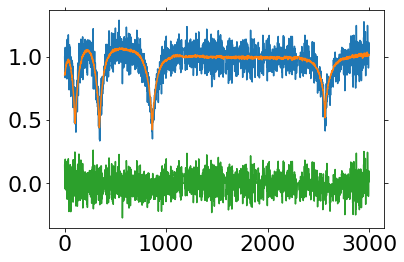

In [178]:
i = np.random.randint(len(allnormspec))
plt.plot(allnormspec[i])
plt.plot(predictions[i])
plt.plot(residuals[i])

### Filter Residuals

In [197]:
where = (residuals < -1)+(residuals > 1)
residuals[where] = 0

### Shapiro-Wilk Test

In [198]:
shaps = [];

for i in range(len(residuals)):
    shaps.append(stats.shapiro(residuals[i])[0])
    
shaps = np.asarray(shaps)

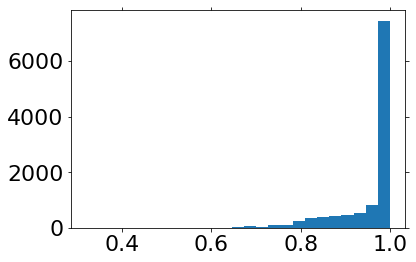

In [199]:
plt.hist(shaps,bins=25);

In [200]:
n_outliers = 50

In [201]:
outlieridx = (shaps).argsort()[:n_outliers]

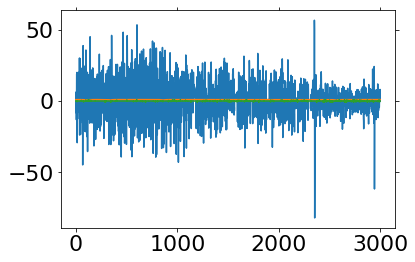

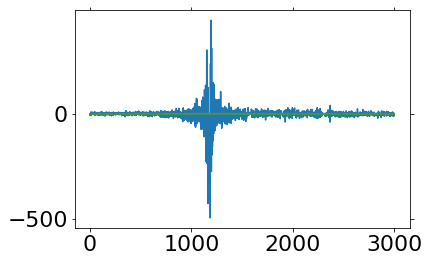

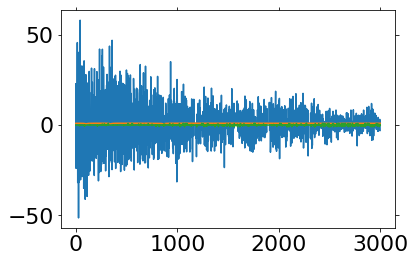

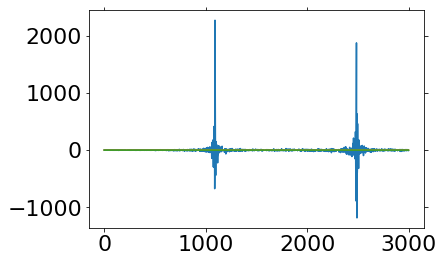

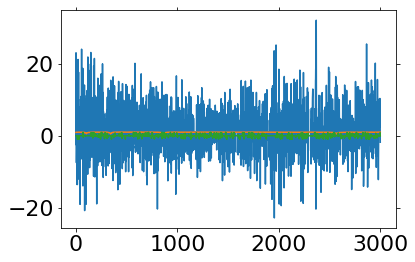

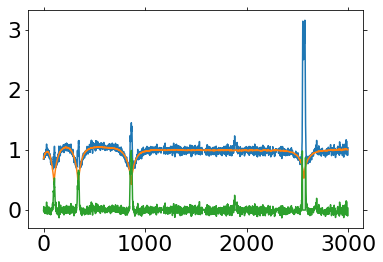

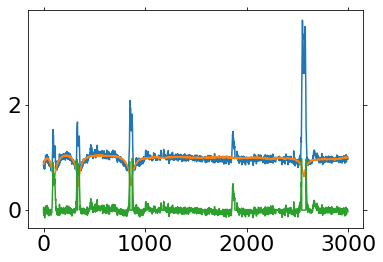

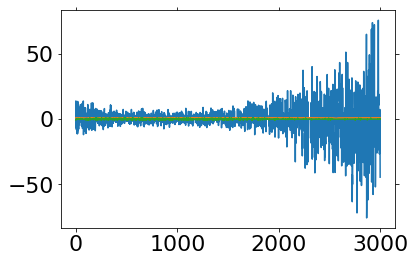

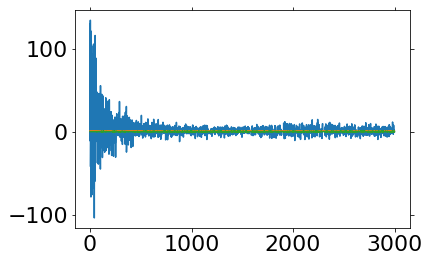

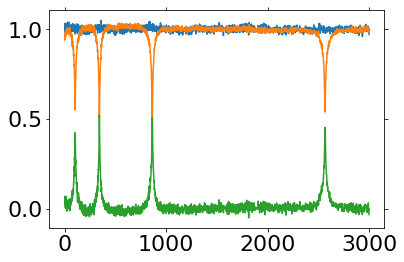

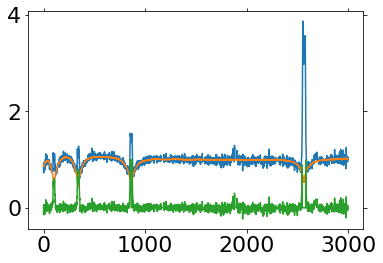

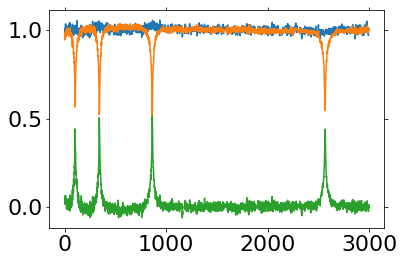

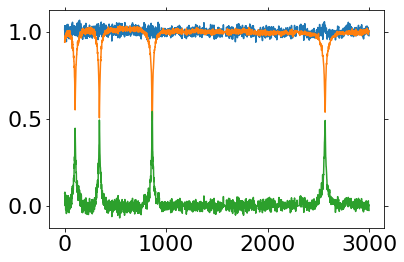

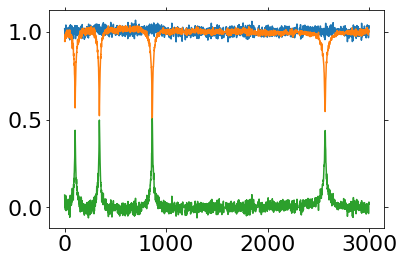

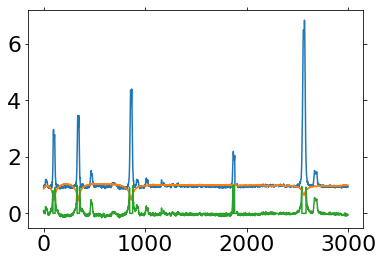

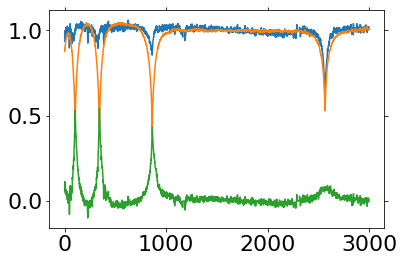

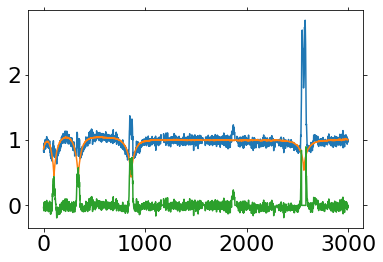

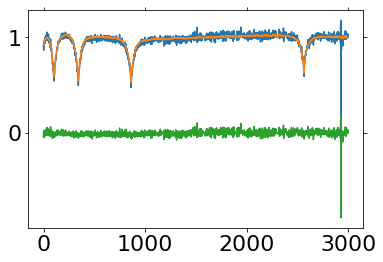

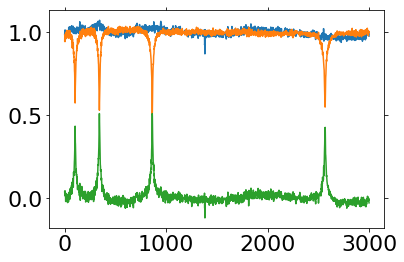

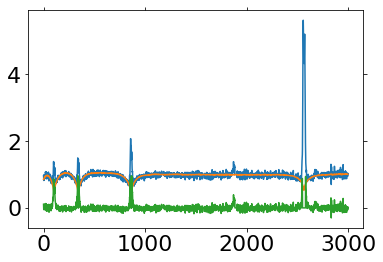

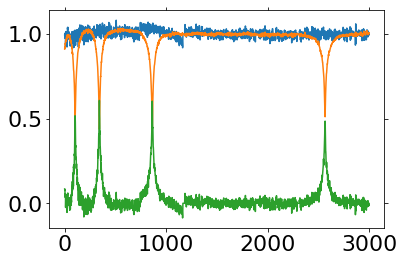

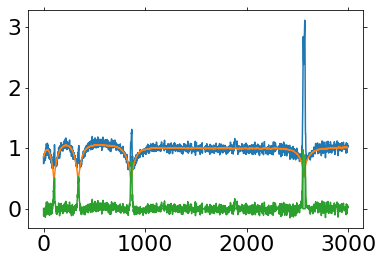

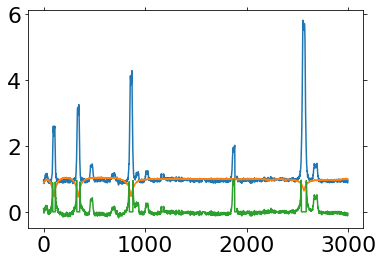

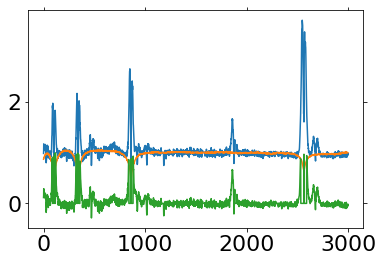

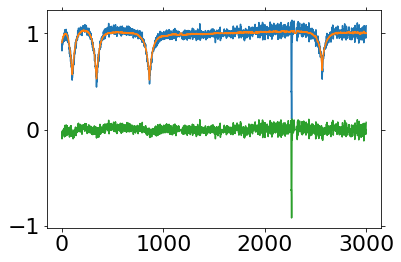

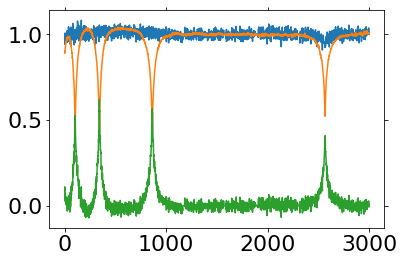

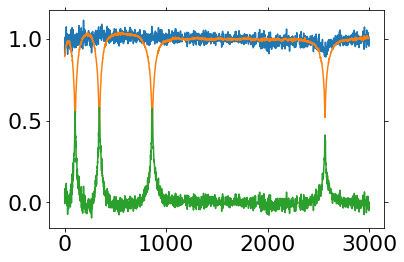

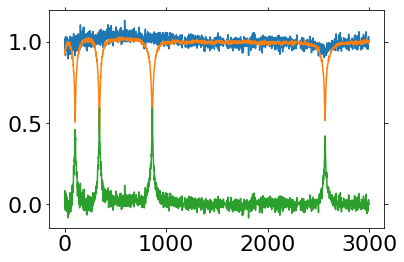

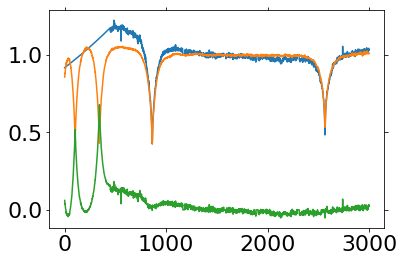

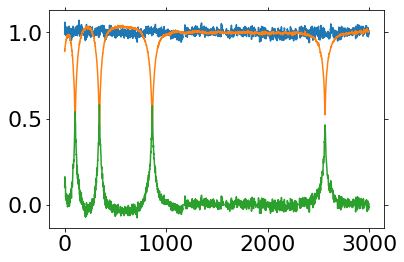

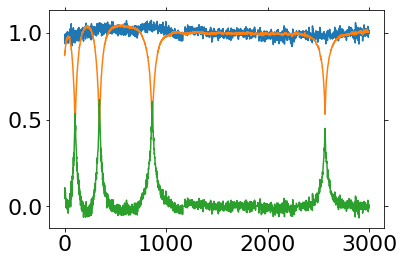

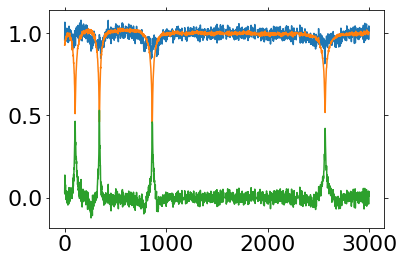

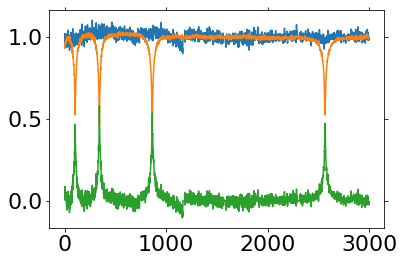

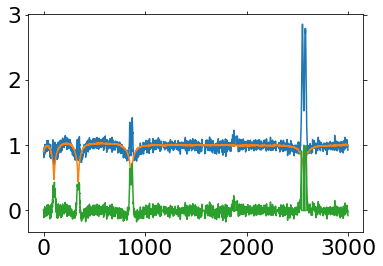

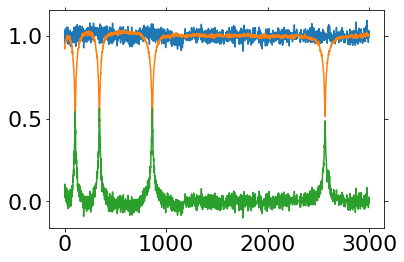

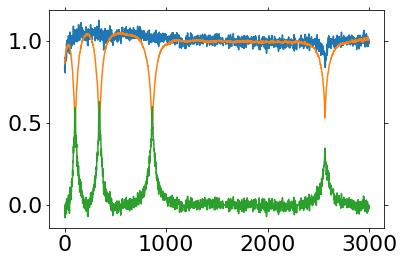

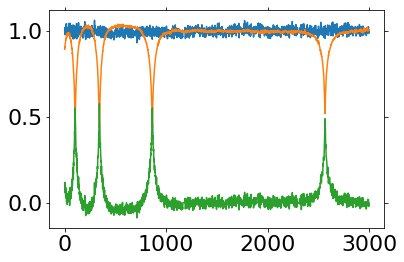

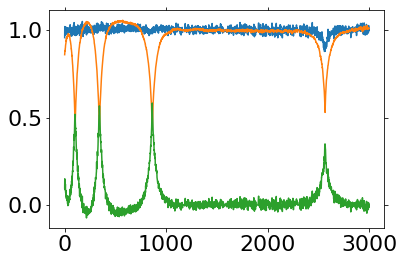

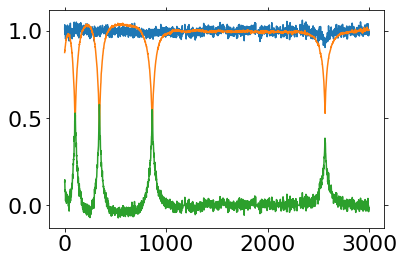

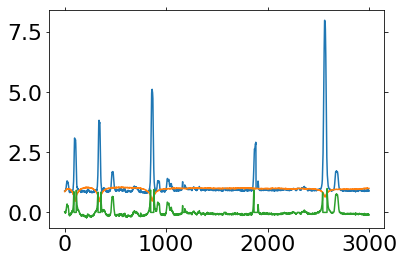

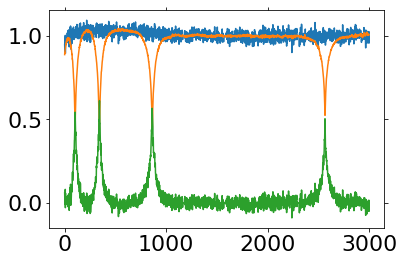

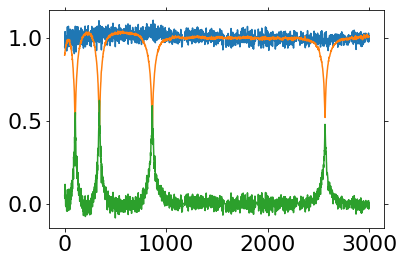

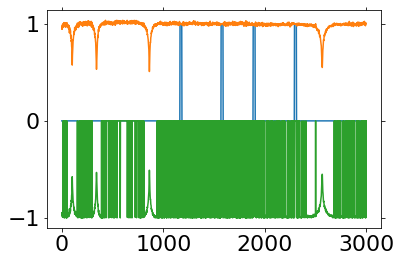

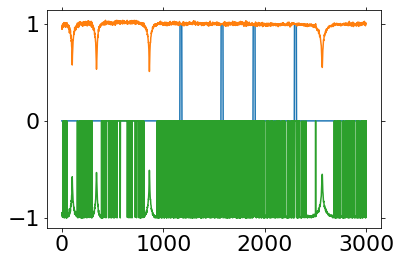

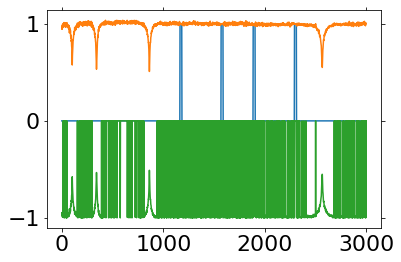

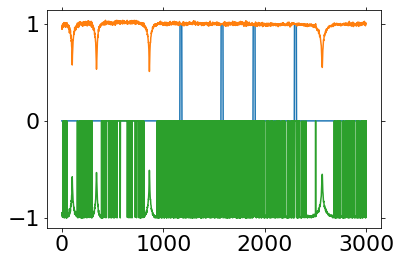

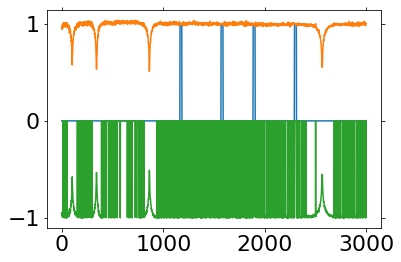

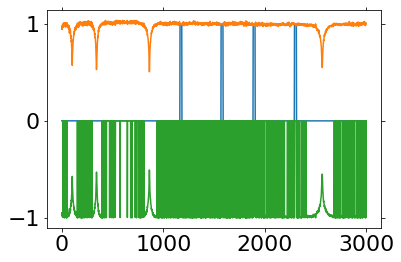

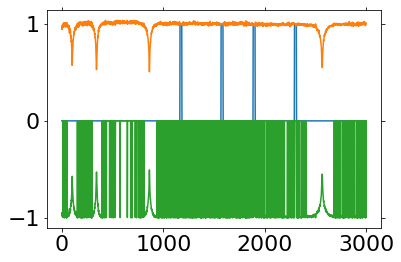

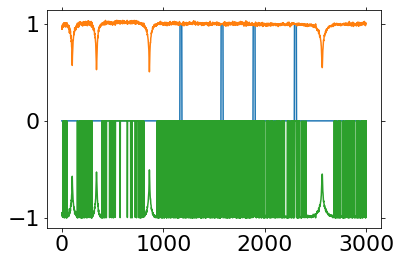

In [202]:
for i in outlieridx:
    plt.figure()
    plt.plot(allnormspec[i])
    plt.plot(predictions[i])
    plt.plot(residuals[i])
    plt.show()
    #plt.title(specnames[i])

### Dalya RF on Residuals

In [204]:
import numpy
def return_synthetic_data(X):
    """
    The function returns a matrix with the same dimensions as X but with synthetic data
    based on the marginal distributions of its featues
    """
    features = len(X[0])
    X_syn = numpy.zeros(X.shape)

    for i in range(features):
        obs_vec = X[:,i]
        syn_vec = numpy.random.choice(obs_vec, len(obs_vec)) # here we chose the synthetic data to match the marginal distribution of the real data
        X_syn[:,i] = X_syn[:,i] + syn_vec

    return X_syn
residuals_syn = return_synthetic_data(residuals)

In [205]:
def merge_work_and_synthetic_samples(X, X_syn):
    """
    The function merges the data into one sample, giving the label "1" to the real data and label "2" to the synthetic data
    """
    # build the labels vector
    Y = numpy.ones(len(X))
    Y_syn = numpy.ones(len(X_syn)) * 2

    Y_total = numpy.concatenate((Y, Y_syn))
    X_total = numpy.concatenate((X, X_syn))
    return X_total, Y_total

X_total, Y_total = merge_work_and_synthetic_samples(residuals, residuals_syn)

In [216]:
from sklearn.ensemble import RandomForestClassifier
N_TRAIN = 100 # number of trees in the forest
rand_f = RandomForestClassifier(n_estimators=N_TRAIN)
rand_f.fit(X_total, Y_total)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
def build_similarity_matrix(rand_f, X):
    """
    The function builds the similarity matrix based on the feature matrix X for the results Y
    based on the random forest we've trained
    the matrix is normalised so that the biggest similarity is 1 and the lowest is 0

    This function counts only leaves in which the object is classified as a "real" object 
    it is also implemented to optimize running time, asumming one has enough running memory
    """
    # apply to get the leaf indices
    apply_mat = rand_f.apply(X)
    # find the predictions of the sample
    is_good_matrix = numpy.zeros(apply_mat.shape)
    for i, est in enumerate(rand_f.estimators_):
        d = est.predict_proba(X)[:, 0] == 1
        is_good_matrix[:, i] = d
    # mark leaves that make the wrong prediction as -1, in order to remove them from the distance measurement
    apply_mat[is_good_matrix == False] = -1 
    # now calculate the similarity matrix
    sim_mat = numpy.sum((apply_mat[:, None] == apply_mat[None, :]) & (apply_mat[:, None] != -1) & (apply_mat[None, :] != -1), axis=2) / numpy.asfarray(numpy.sum([apply_mat != -1], axis=2), dtype='float')
    return sim_mat

sim_mat = build_similarity_matrix(rand_f, residuals)
dis_mat = 1 - sim_mat

Text(0.5, 0, 'weirdness score')

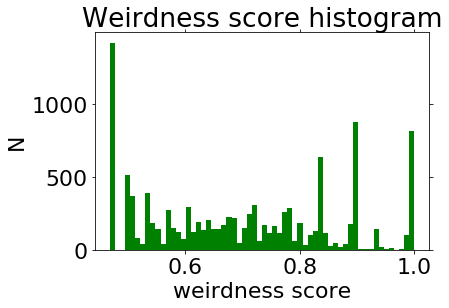

In [211]:
sum_vec = numpy.sum(dis_mat, axis=1)
sum_vec /= float(len(sum_vec))

plt.rcParams['figure.figsize'] = 6, 4
plt.title("Weirdness score histogram")
tmp = plt.hist(sum_vec, bins=60, color="g")
plt.ylabel("N")
plt.xlabel("weirdness score")

In [213]:
obj_ids = np.asarray(range(len(residuals)))
N_outliers = 50
sum_vec_outliers = numpy.sort(sum_vec)[::-1][:N_outliers]
obj_ids_outliers = obj_ids[numpy.argsort(sum_vec)][::-1][:N_outliers]

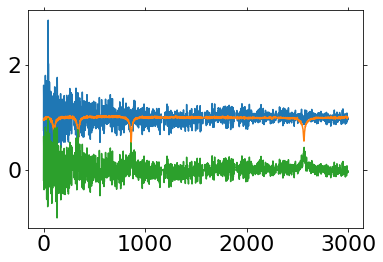

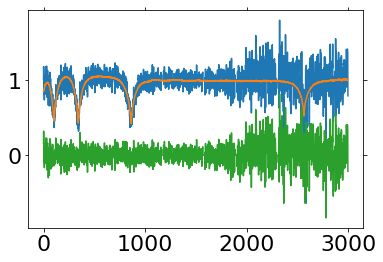

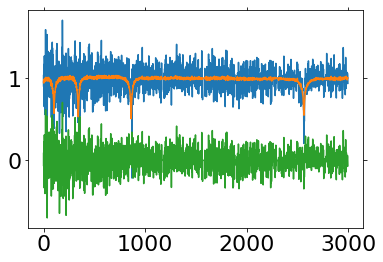

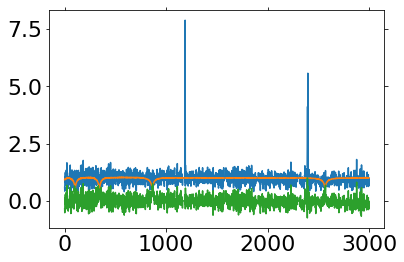

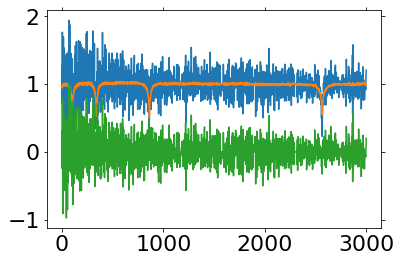

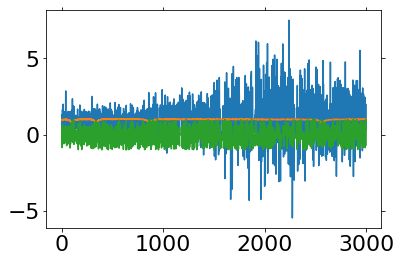

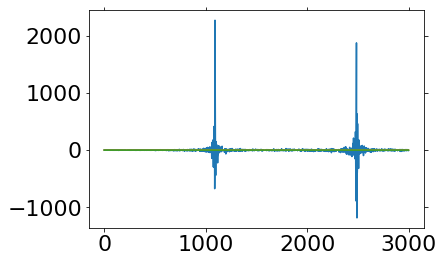

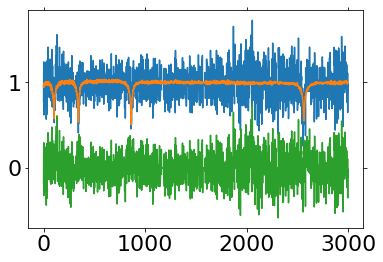

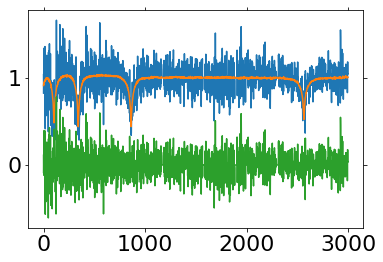

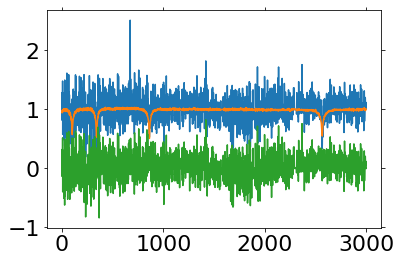

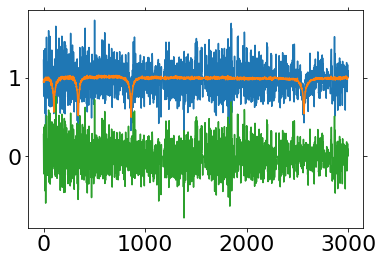

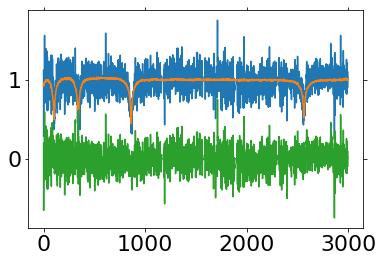

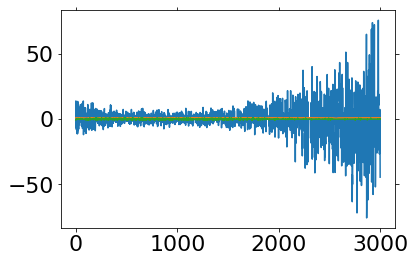

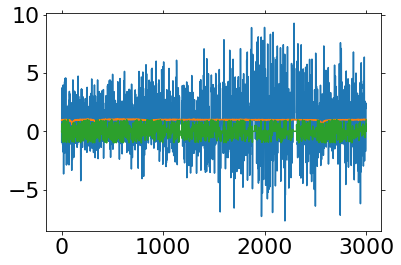

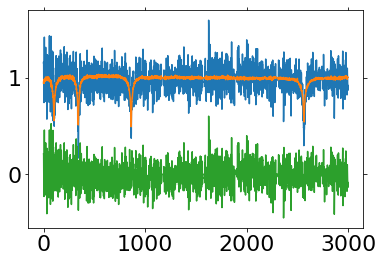

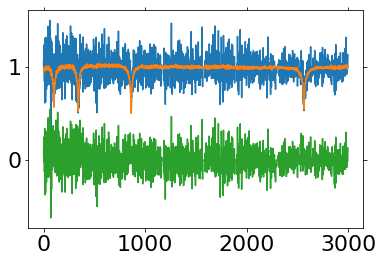

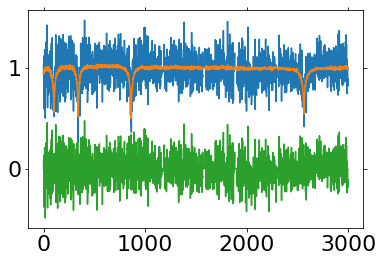

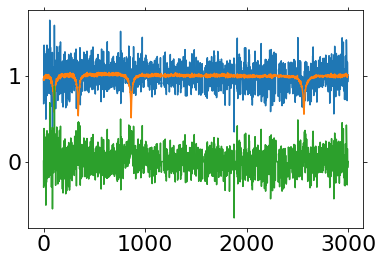

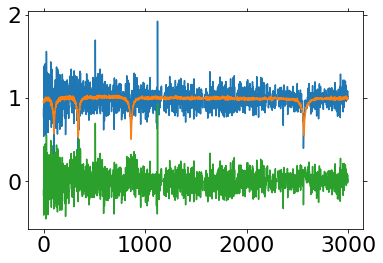

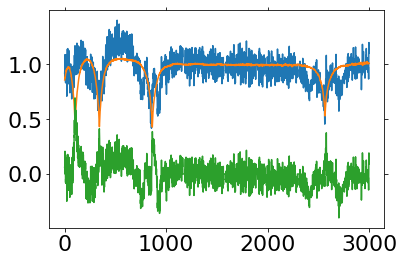

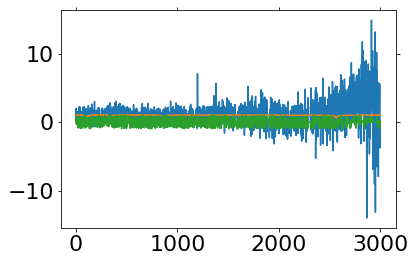

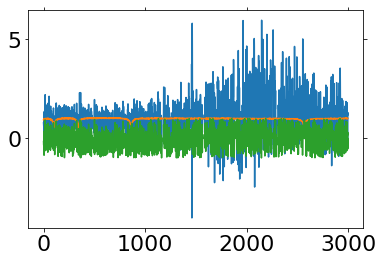

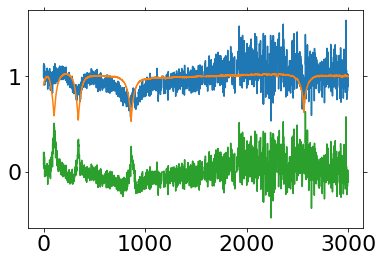

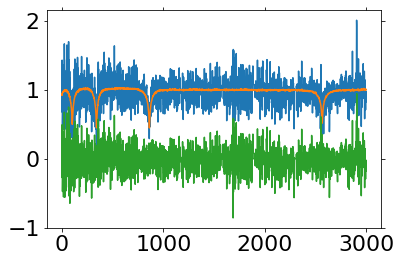

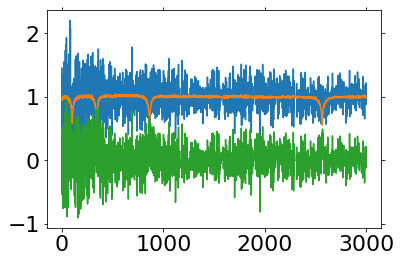

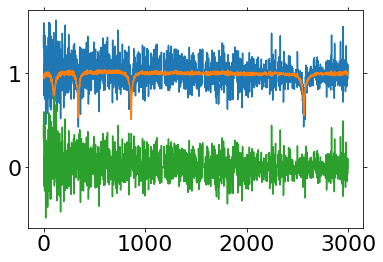

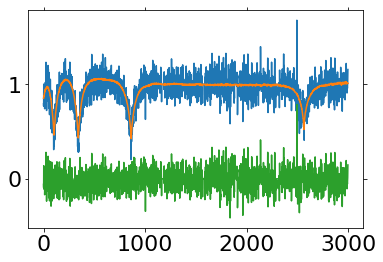

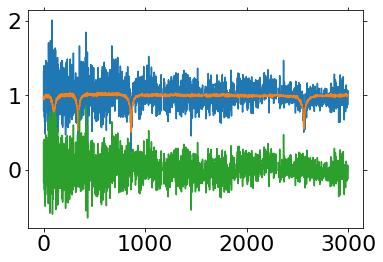

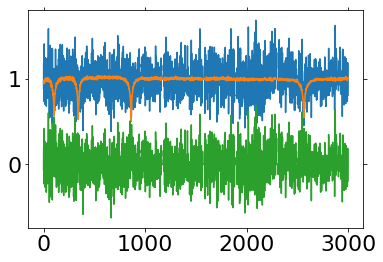

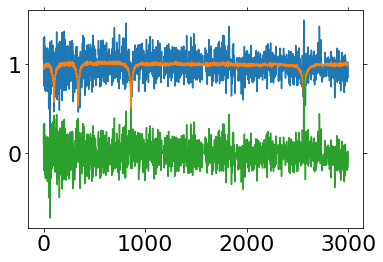

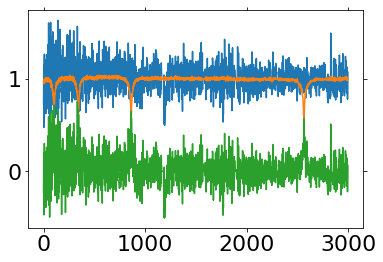

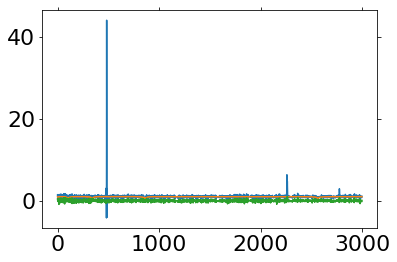

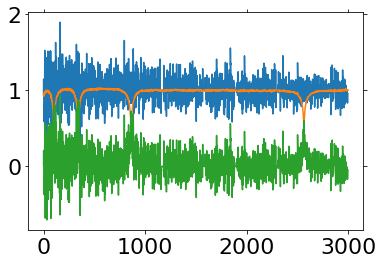

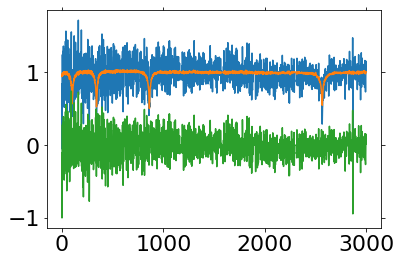

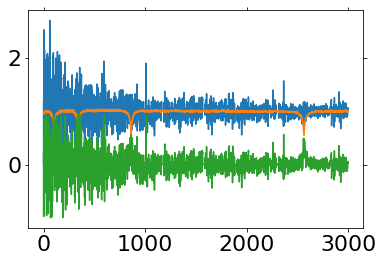

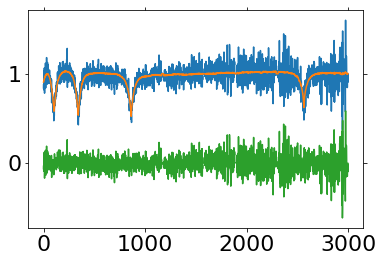

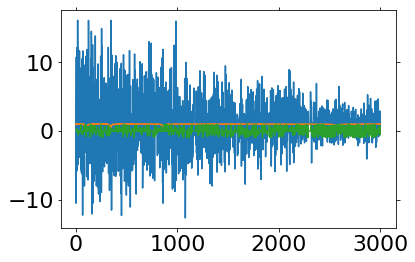

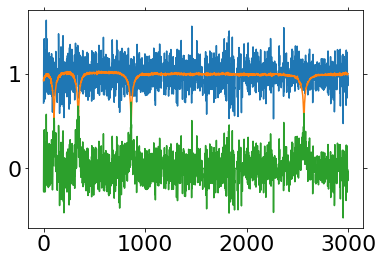

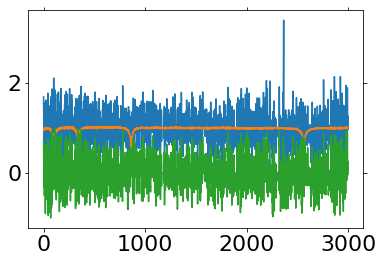

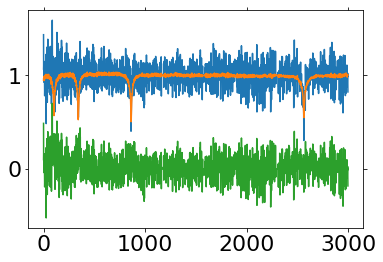

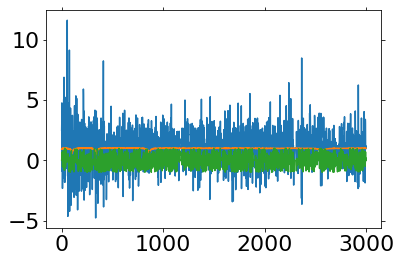

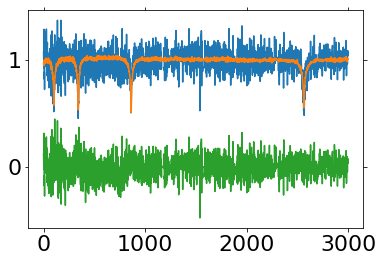

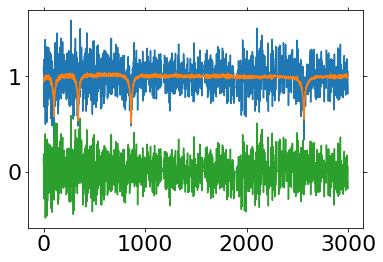

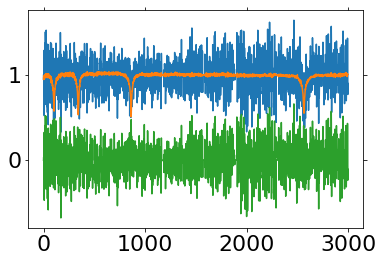

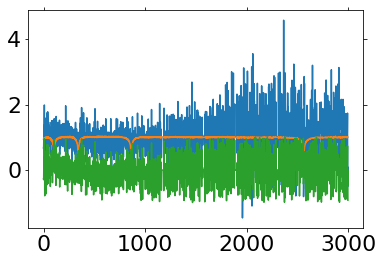

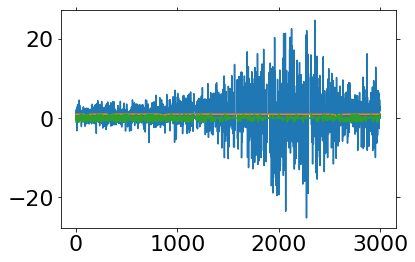

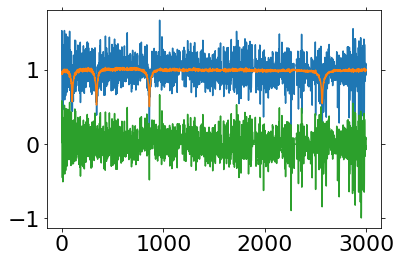

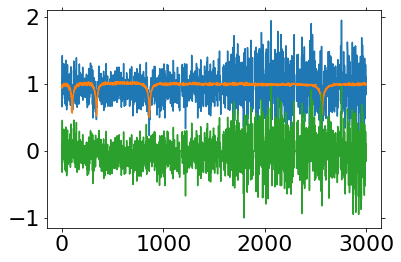

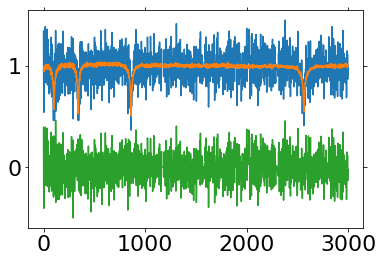

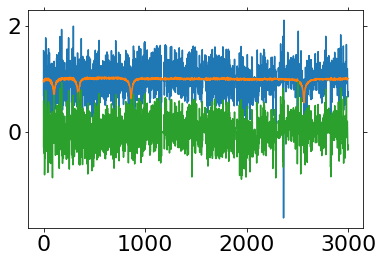

In [215]:
for i in obj_ids_outliers:
    plt.figure()
    plt.plot(allnormspec[i])
    plt.plot(predictions[i])
    plt.plot(residuals[i])
    plt.show()
    #plt.title(specnames[i])

## Fitter

In [101]:
filename = ['4487216358658978560_spec_0.fits']

In [76]:

spectra = []
TeffHs = []
loggHs = []
specnames = []
for specname in tqdm(filename):
    f = fits.open(inputPath+specname)
    loglam = f[1].data['loglam']
    flux = f[1].data['flux']
    lam = 10**loglam
    lam = lam.astype(np.float64)
    flux = flux.astype(np.float64)
    lamgrid = np.arange(4000,8000)
    func = interp1d(lam,flux,kind='cubic',assume_sorted = False,fill_value='extrapolate')
    flux = func(lamgrid)
    spectra.append(flux)
    specnames.append(specname)
spectra = np.asarray(spectra)
TeffHs = np.asarray(TeffHs)
loggHs = np.asarray(loggHs)
bprps = np.asarray(bprps)
gs = np.asarray(gs)

lam = np.arange(4000,8000)
lamgrid = lam
lines = ((lam > hbeta-300) & (lam < hbeta + 300)) | ((lam > halpha-400) & (lam < halpha + 400))\
        | ((lam > hgamma-400) & (lam < hgamma + 200))

mask = ~lines | ((lam > 4010) & (lam < 4050)) | ((lam > 4190) & (lam < 4230))
def quadratic(array,c1,c2,c3,c4):
    return c1 + c2*array + c3*array**2 + c4*array**3

normspec = [];

for i in tqdm(range(len(spectra))):
    p,cov = curve_fit(quadratic,lamgrid[mask],spectra[i][mask],p0=[-25,1e-2,1e-5,1e-10])
    contcorr = (spectra[i]/quadratic(lam,p[0],p[1],p[2],p[3]))
    skylinemask = (lamgrid > 5578.5 - 10)*(lamgrid < 5578.5 + 10) + (lamgrid > 5894.6 - 10)*(lamgrid < 5894.6 + 10)\
        + (lamgrid > 6301.7 - 10)*(lamgrid < 6301.7 + 10) + (lamgrid > 7246.0 - 10)*(lamgrid < 7246.0 + 10)
    contcorr[skylinemask] = 1
    #contcorr = rvcorr(contcorr)
    #contcorr = np.log(contcorr)
    where = np.isnan(contcorr)
    contcorr[where] = 0
    normspec.append(contcorr[0:3000])
normspec = np.asarray(normspec)
len(normspec)

100%|██████████| 1/1 [00:00<00:00, 316.62it/s]


1






  0%|          | 0/1 [00:00<?, ?it/s]

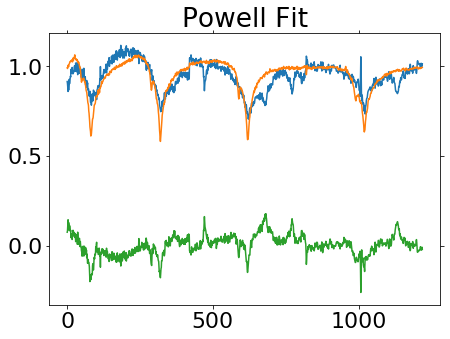

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 220
    # data points      = 1220
    # variables        = 3
    chi-square         = 3.91403212
    reduced chi-square = 0.00321613
    Akaike info crit   = -6999.28644
    Bayesian info crit = -6983.96662
[[Variables]]
    bprp:   0.66555304 +/- 0.25288212 (38.00%) (init = 0)
    absg:   14.1209329 +/- 0.02299075 (0.16%) (init = 10)
    trans: -31.3796607 +/- 0.40222709 (1.28%) (init = 0)

 Starting Bayesian Sampling................
...Done.


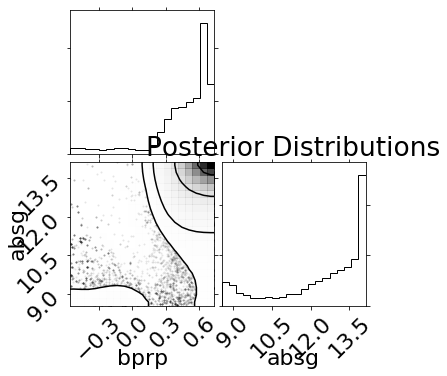

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 25000
    # data points      = 1220
    # variables        = 2
    chi-square         = 3.93310060
    reduced chi-square = 0.00322915
    Akaike info crit   = -6995.35724
    Bayesian info crit = -6985.14403
[[Variables]]
    bprp:   0.53418290 +/- 0.19909320 (37.27%) (init = 0.665553)
    absg:   13.0073908 +/- 1.95126954 (15.00%) (init = 14.12093)
    trans: -31.37966 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(bprp, absg) =  0.583


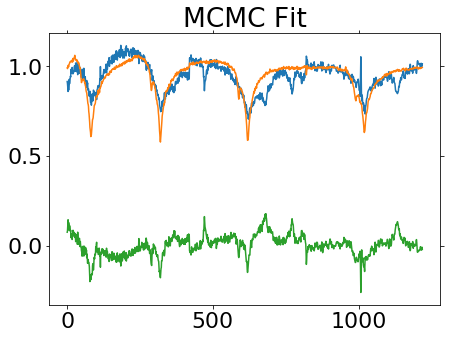






100%|██████████| 1/1 [00:35<00:00, 35.15s/it]

In [98]:
modelscaling = 1
from astropy.convolution import Gaussian1DKernel
from scipy.signal import convolve as scipy_convolve
def spectrum_sampler(wl,bprp,absg,trans):
    label = sc.transform(np.asarray(np.stack((bprp,absg)).reshape(1,-1)))
    synth = (interpolation.shift(model.predict(label)[0],trans,cval=np.nan)*modelscaling)
    newsynth = scipy_convolve(synth,Gaussian1DKernel(5),'same')
    return msc.inverse_transform(synth)[lines].astype('float32')

def chisquare(residual):
    return sum(residual**2)

lamgrid = np.arange(4000,7000)
fitter = lmfit.Model(spectrum_sampler)
params = fitter.make_params(bprp = 0.,absg=10.,trans=0.)
lam = lamgrid
lines = lines = ((lam > hbeta-200) & (lam < hbeta + 200)) | ((lam > halpha-200) & (lam < halpha + 200))\
        | ((lam > hgamma-320) & (lam < hgamma + 100))

params['bprp'].set(min=np.min(bprps),max=np.max(bprps))
params['absg'].set(min=np.min(gs),max=np.max(gs))

bayesparams = fitter.make_params(bprp = 0.,absg=10.,trans=0.)
bayesparams['bprp'].set(min=np.min(bprps),max=np.max(bprps))
bayesparams['absg'].set(min=np.min(gs),max=np.max(gs))

fitoutput = np.zeros((len(normspec),5))
bayesoutput = np.zeros((len(normspec),5))
for i in tqdm(range(len(normspec))):
    spec = normspec[i][lines]
    fitoutput[i,0] = int(specnames[i][:-12])
    bayesoutput[i,0] = int(specnames[i][:-12])
    result = fitter.fit(spec*modelscaling,params,wl=lamgrid[lines],method="powell",nan_policy='omit',calc_covar=True,
                       fit_kws={'reduce_fcn':chisquare})
    
    fitoutput[i,1] = result.params['bprp'].value
    fitoutput[i,2] = result.params['bprp'].stderr
    fitoutput[i,3] = result.params['absg'].value
    fitoutput[i,4] = result.params['absg'].stderr
    
    plt.figure(figsize=(7,5))
    plt.plot(spec*modelscaling)
    plt.plot(spectrum_sampler(None,result.params['bprp'],result.params['absg'],result.params['trans']))
    plt.plot(result.residual)
    plt.title('Powell Fit')
    plt.show()
    print(lmfit.fit_report(result))
    
    # BAYESIAN FITTING ##
    
    bayesparams['bprp'].set(value = result.params['bprp'].value)
    bayesparams['absg'].set(value = result.params['absg'].value)
    print('\n Starting Bayesian Sampling................')
    bayesparams['trans'].set(value = result.params['trans'].value,vary=False)
    bayesresult = fitter.fit(spec*modelscaling,bayesparams,wl=lamgrid[lines],method="emcee",nan_policy='omit',\
                             calc_covar=True, fit_kws={'nwalkers':100,'steps':250})
    print('...Done.')
    f = corner.corner(bayesresult.flatchain[['bprp','absg']],smooth=2)
    plt.title('Posterior Distributions')
    plt.show()
    print(lmfit.fit_report(bayesresult))
    plt.figure(figsize=(7,5))
    plt.plot(spec*modelscaling)
    plt.plot(spectrum_sampler(None,bayesresult.params['bprp'],bayesresult.params['absg'],bayesresult.params['trans']))
    plt.plot(result.residual)
    plt.title('MCMC Fit')
    plt.show()
    bayesoutput[i,1] = bayesresult.params['bprp'].value
    bayesoutput[i,2] = bayesresult.params['bprp'].stderr
    bayesoutput[i,3] = bayesresult.params['absg'].value
    bayesoutput[i,4] = bayesresult.params['absg'].stderr

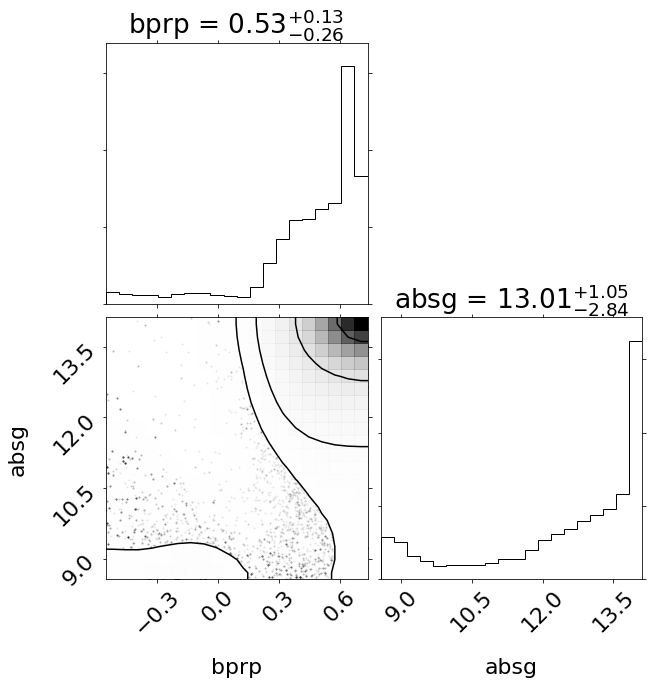

In [103]:
fig,axs = plt.subplots(2,2,figsize=(10,10))
f = corner.corner(bayesresult.flatchain[['bprp','absg']],smooth=2,fig=fig,show_titles = True)
plt.show()

### Evaluate Residuals of Random Control Spectra

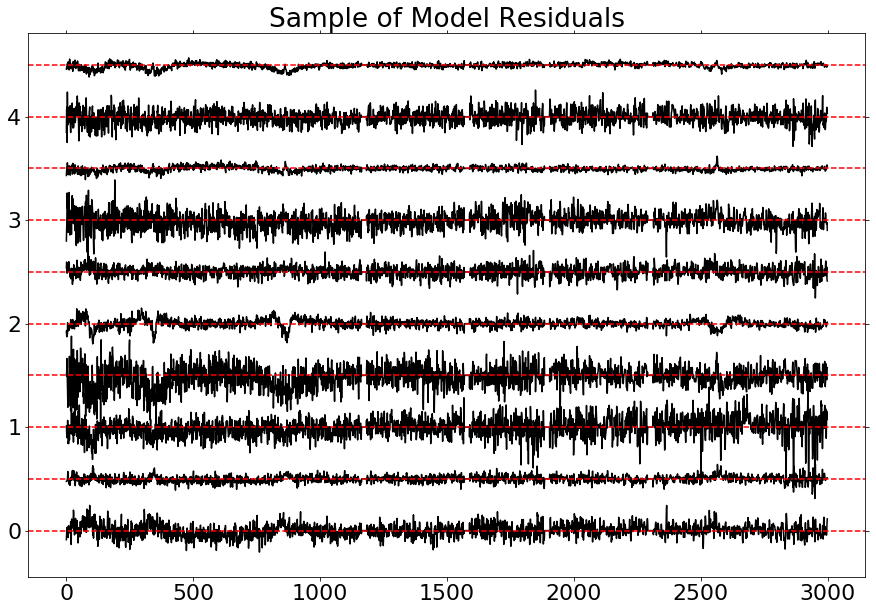

In [104]:
resids = msc.inverse_transform(model.predict(X))- msc.inverse_transform(t) 
plt.figure(figsize=(15,10))
ct=0
for i in np.random.randint(0,len(resids),10):
    plt.plot(resids[i] + 0.5*ct,'k')
    plt.axhline(0.5*ct,color='r',linestyle='--')
    ct += 1
    plt.title('Sample of Model Residuals')

In [207]:
preds = msc.inverse_transform(model.predict(X))
reals = msc.inverse_transform(t)
labels = sc.inverse_transform(X)

Text(0.5, 1.0, 'BP-RP = ')

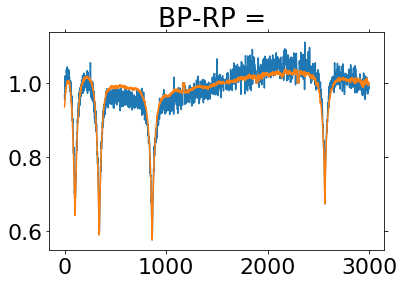

In [208]:
i = 35

label = labels[i]
plt.plot(reals[i])
plt.plot(preds[i])
plt.title('BP-RP = ')

## Autocorr Method

In [260]:
resids = msc.inverse_transform(model.predict(X)) - msc.inverse_transform(t)

In [261]:
autos = [];
corrtimes = [];
for i in range(len(resids)):
    autocorr = np.correlate(resids[i],resids[i],mode='full')
    autocorr = autocorr/max(autocorr)
    corrtime = sum(autocorr)
    autos.append(autocorr)
    corrtimes.append(corrtime)

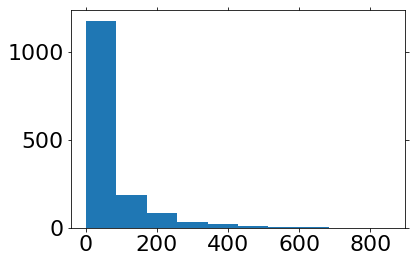

In [262]:
plt.hist(corrtimes,bins=10);

In [270]:
outliers = np.asarray(corrtimes) > 600
outspec = normspec[outliers]
outpred = msc.inverse_transform(model.predict(X)[outliers])
outlabel = sc.inverse_transform(X[outliers])
outresids = resids[outliers]
outautos = np.asarray(autos)[outliers]
len(X[outliers])

4

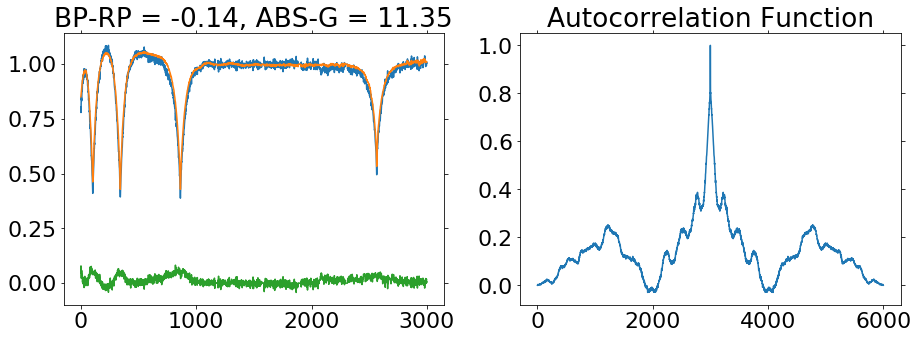

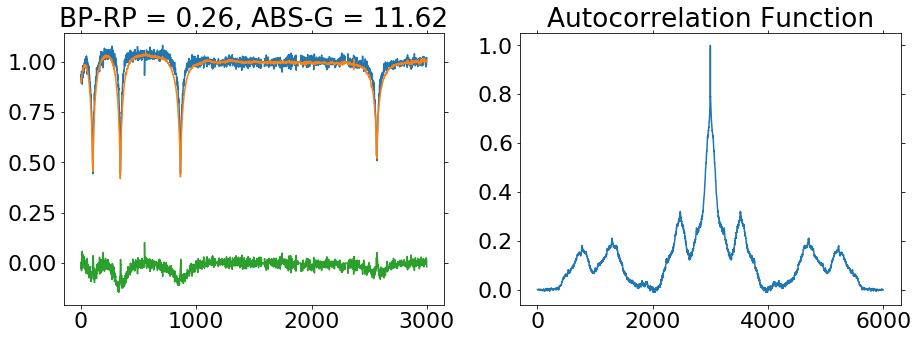

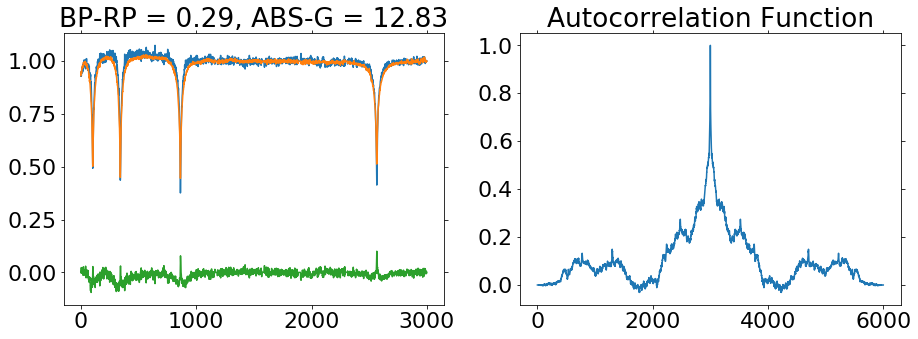

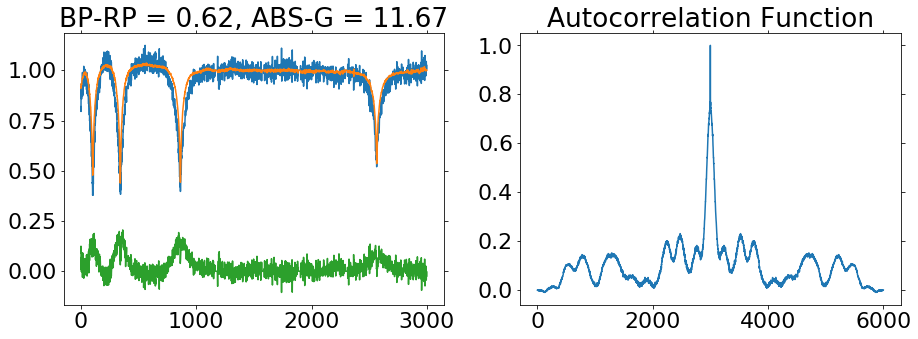

In [271]:
for i in range(sum(outliers)):
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.plot(outspec[i],label='Data')
    plt.title('BP-RP = %.2f, ABS-G = %0.2f'%(outlabel[i][0],outlabel[i][1]))
    plt.plot(outpred[i],label='Prediction')
    plt.plot(outresids[i])
    plt.subplot(122)
    plt.title('Autocorrelation Function')
    plt.plot(outautos[i])
    plt.show()

# Shapiro Test

In [67]:
shaps = [];
for i in range(len(resids)):
    shaps.append(stats.shapiro(resids[i])[0])

In [68]:
shaps = np.asarray(shaps)

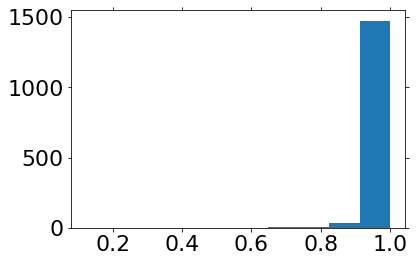

In [69]:
plt.hist(shaps);

In [72]:
outliers = shaps < 0.85

outspec = normspec[outliers]
outpred = msc.inverse_transform(model.predict(X)[outliers])
outlabel = sc.inverse_transform(X[outliers])
outnames = np.asarray(specnames)[outliers]

1434748982169485568_spec_1.fits


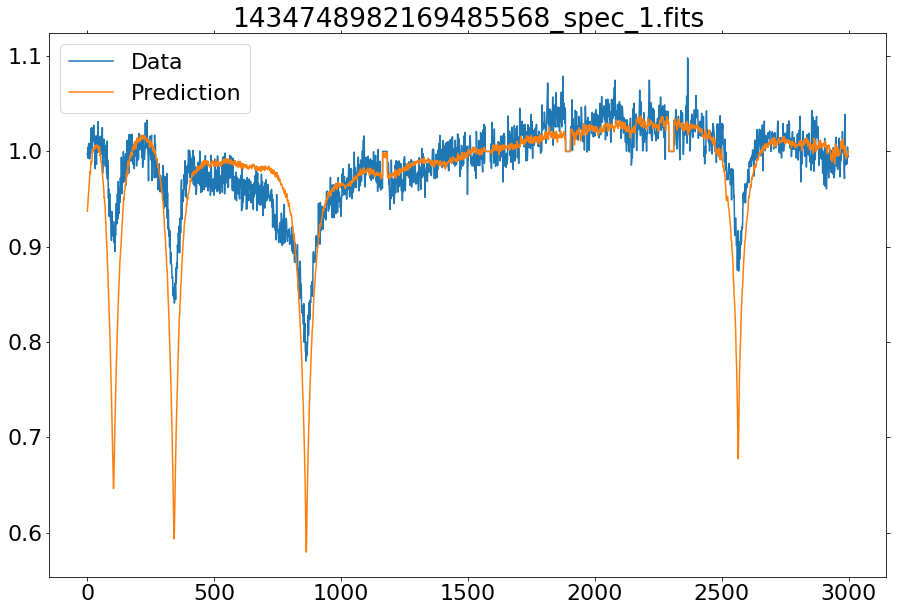

3302538209462061696_spec_0.fits


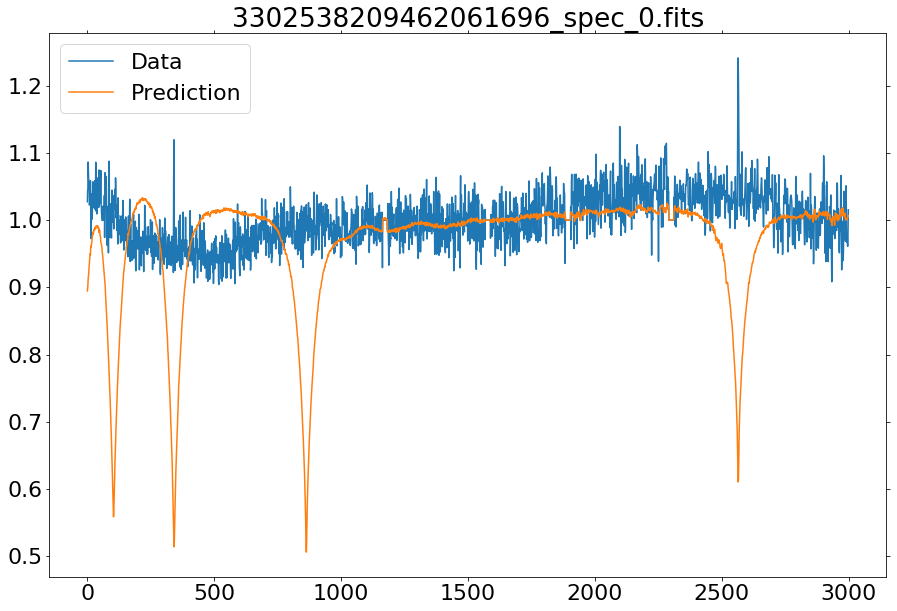

4417843183603168640_spec_2.fits


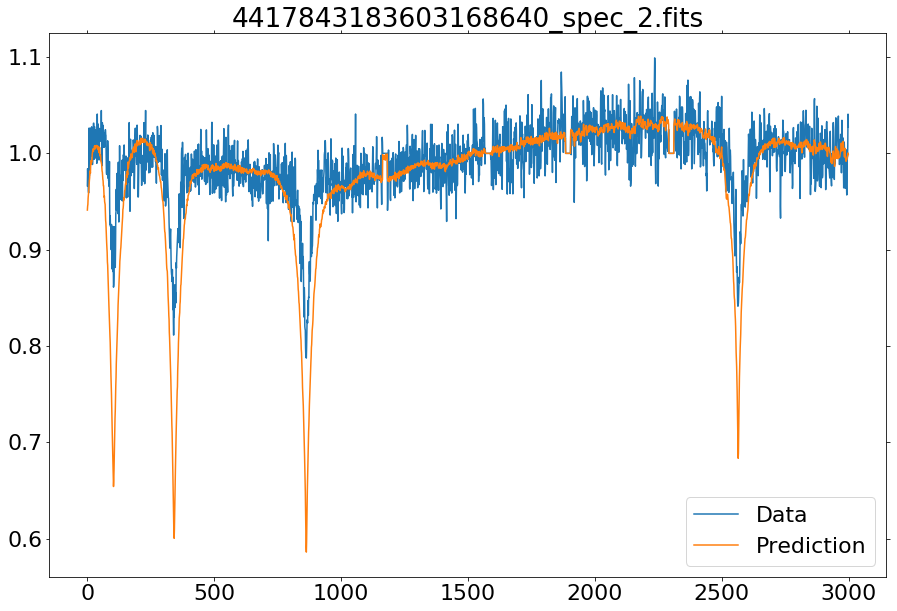

1195463537927048320_spec_0.fits


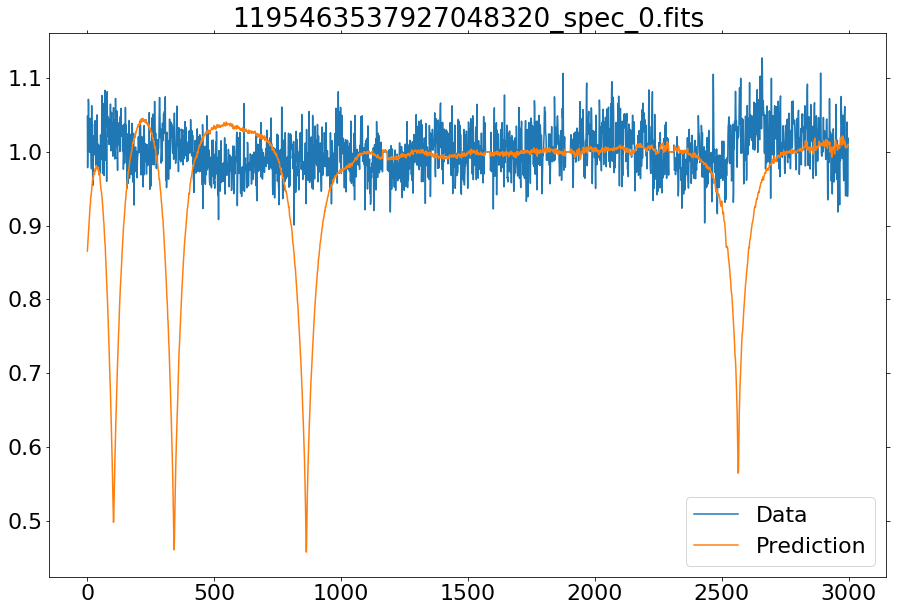

700346923589710080_spec_0.fits


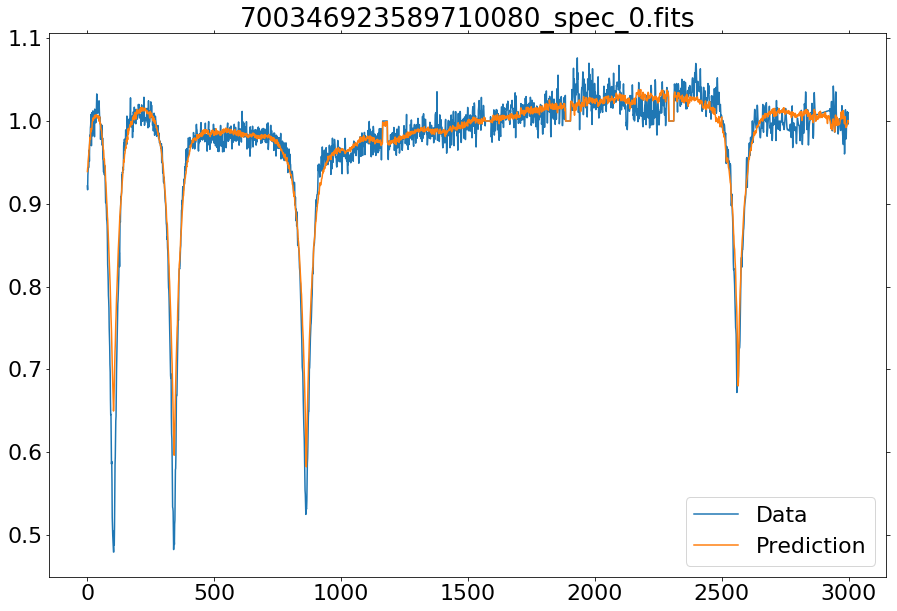

4487216358658978560_spec_0.fits


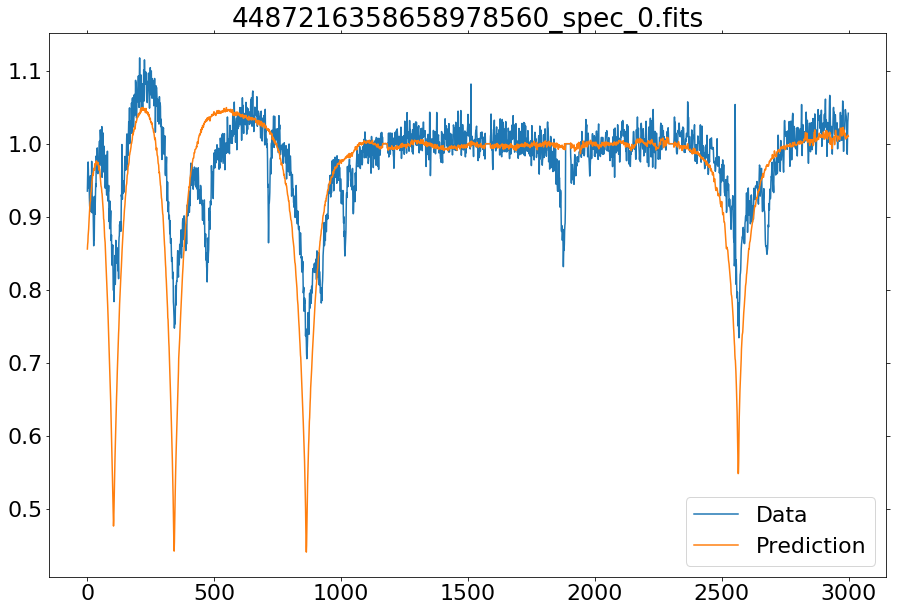

3302526729012505472_spec_0.fits


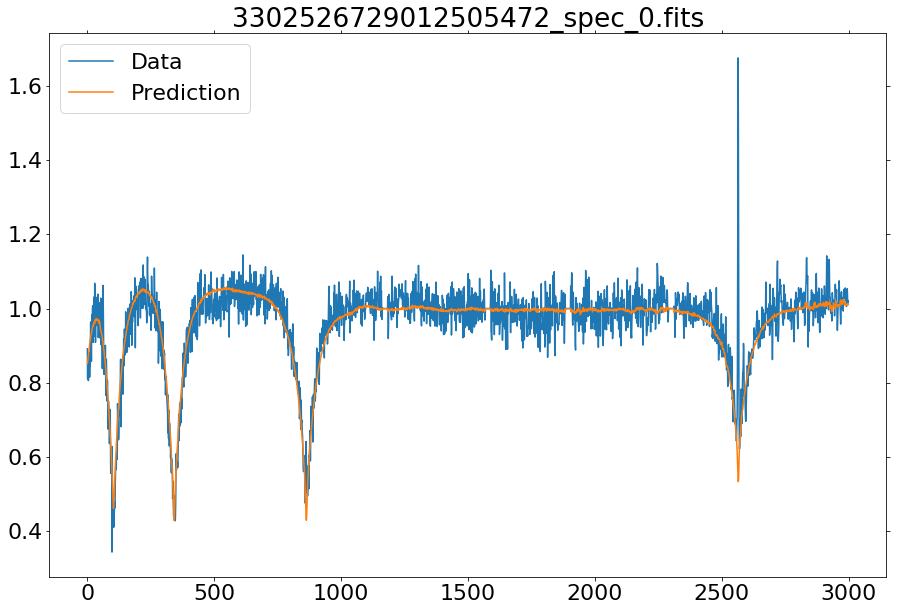

1243679832928795136_spec_0.fits


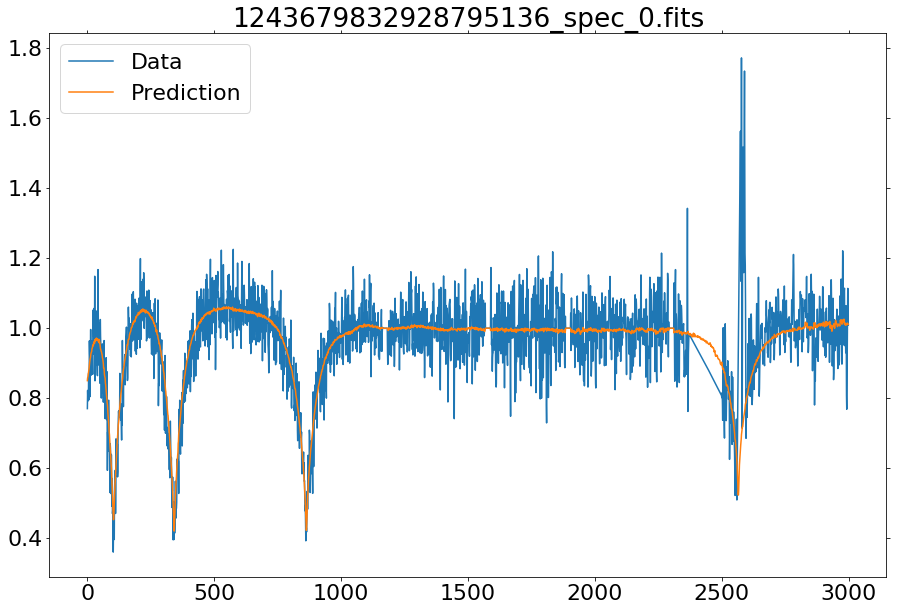

2542961560852591744_spec_0.fits


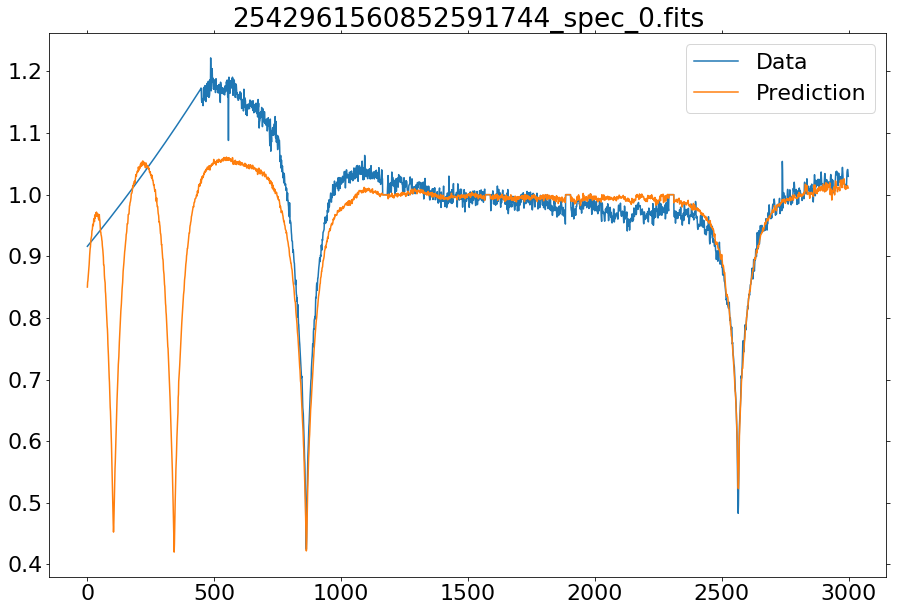

3806602267172416000_spec_0.fits


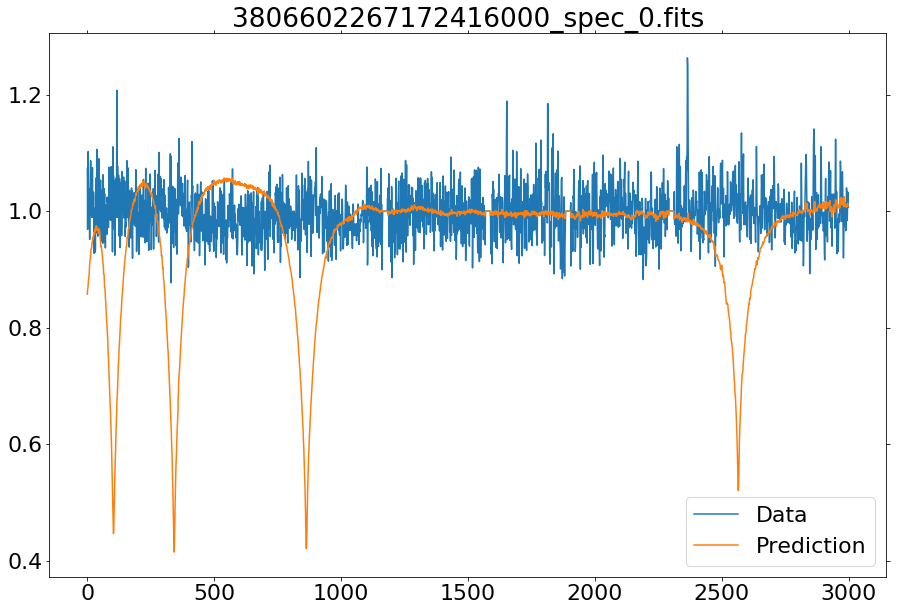

4463904719284925440_spec_0.fits


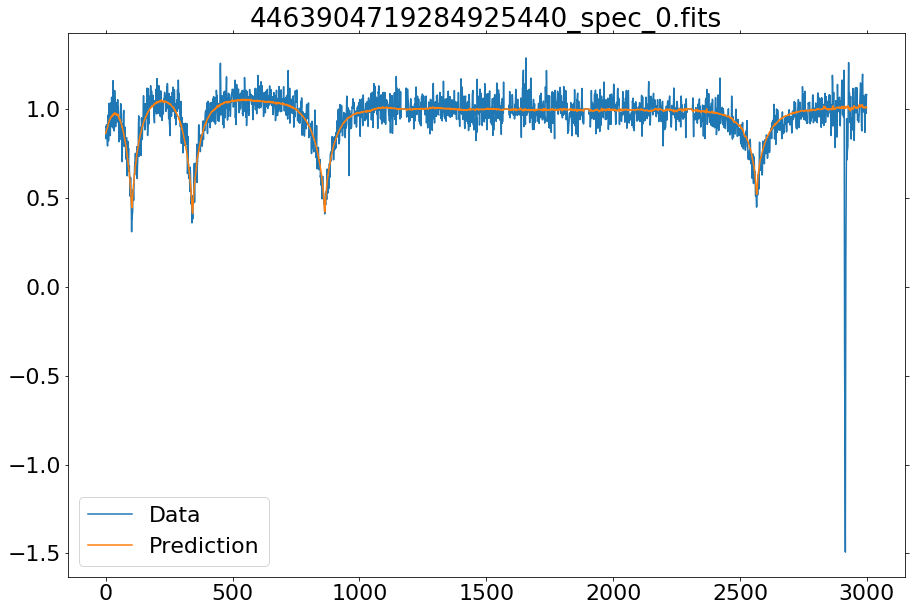

3681955719172822400_spec_0.fits


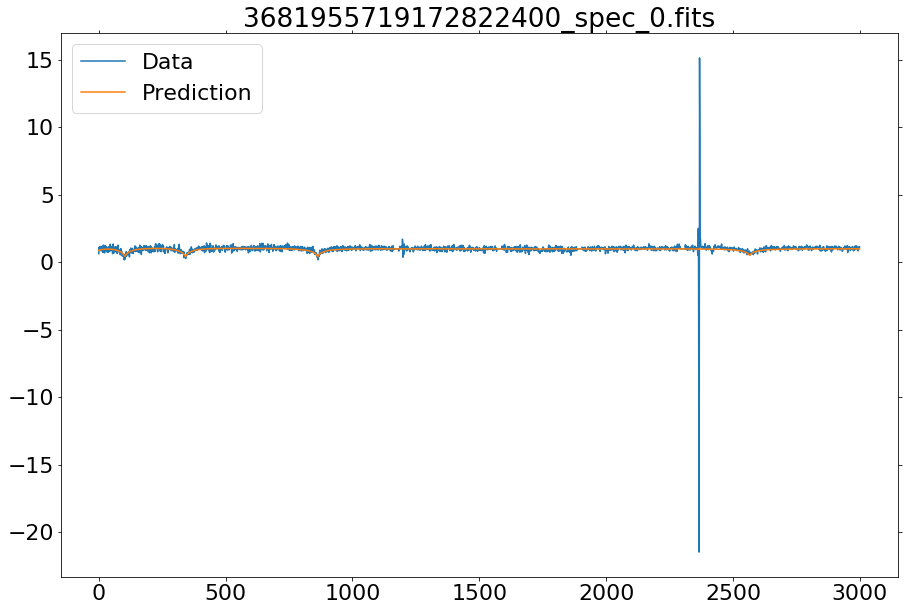

721244821406496640_spec_0.fits


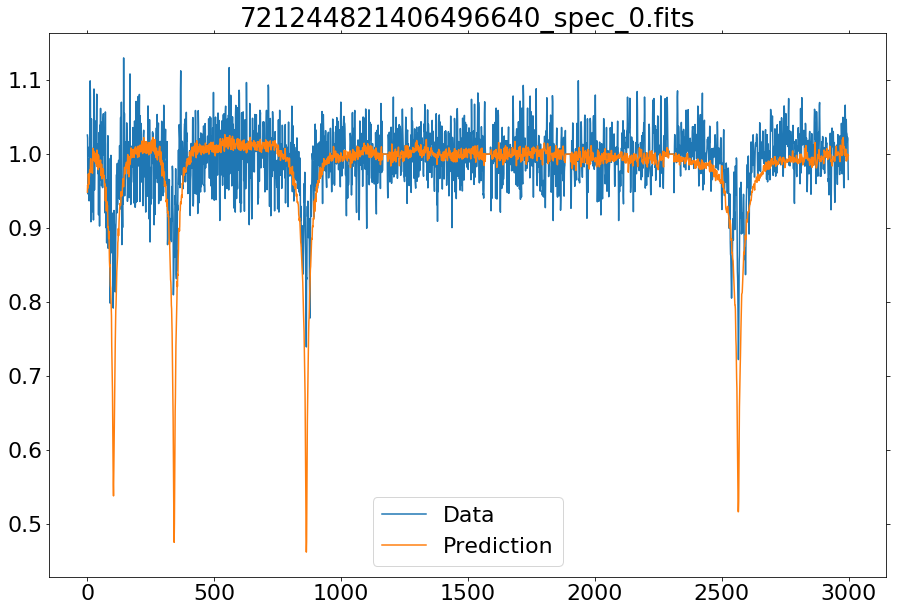

1523116177642231808_spec_0.fits


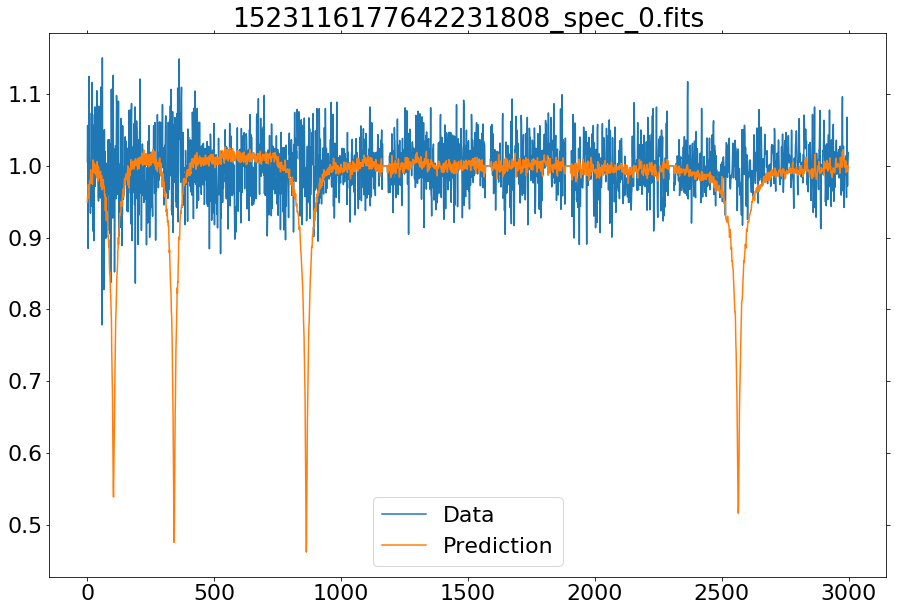

In [74]:
for i in range(sum(outliers)):
    plt.figure(figsize=(15,10))
    plt.plot(outspec[i],label='Data')
    #plt.title('BP-RP = %.2f, ABS-G = %0.2f'%(outlabel[i][0],outlabel[i][1]))
    plt.title(outnames[i])
    plt.plot(outpred[i],label='Prediction')
    plt.legend()
    print(outnames[i])
    plt.show()

# PRF

In [22]:
X_syn = msc.inverse_transform(model.predict(X)) 
X = msc.inverse_transform(t)

In [28]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import scale
from sklearn.model_selection import LeaveOneOut
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,RandomForestClassifier
import numpy
obj_ids = (np.linspace(0,len(X),len(X)+1)).astype(int)

In [29]:
def merge_work_and_synthetic_samples(X, X_syn):
    """
    The function merges the data into one sample, giving the label "1" to the real data and label "2" to the synthetic data
    """
    # build the labels vector
    Y = numpy.ones(len(X))
    Y_syn = numpy.ones(len(X_syn)) * 2

    Y_total = numpy.concatenate((Y, Y_syn))
    X_total = numpy.concatenate((X, X_syn))
    return X_total, Y_total

X_total, Y_total = merge_work_and_synthetic_samples(X, X_syn)

In [54]:
N_TRAIN = 500 # number of trees in the forest
rand_f = RandomForestClassifier(n_estimators=N_TRAIN)
rand_f.fit(X_total, Y_total)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [55]:
def build_similarity_matrix(rand_f, X):
    """
    The function builds the similarity matrix based on the feature matrix X for the results Y
    based on the random forest we've trained
    the matrix is normalised so that the biggest similarity is 1 and the lowest is 0

    This function counts only leaves in which the object is classified as a "real" object 
    it is also implemented to optimize running time, asumming one has enough running memory
    """
    # apply to get the leaf indices
    apply_mat = rand_f.apply(X)
    # find the predictions of the sample
    is_good_matrix = numpy.zeros(apply_mat.shape)
    for i, est in enumerate(rand_f.estimators_):
        d = est.predict_proba(X)[:, 0] == 1
        is_good_matrix[:, i] = d
    # mark leaves that make the wrong prediction as -1, in order to remove them from the distance measurement
    apply_mat[is_good_matrix == False] = -1 
    # now calculate the similarity matrix
    sim_mat = numpy.sum((apply_mat[:, None] == apply_mat[None, :]) & (apply_mat[:, None] != -1) & (apply_mat[None, :] != -1), axis=2) / numpy.asfarray(numpy.sum([apply_mat != -1], axis=2), dtype='float')
    return sim_mat

sim_mat = build_similarity_matrix(rand_f, X)
dis_mat = 1 - sim_mat

Text(0.5, 0, 'weirdness score')

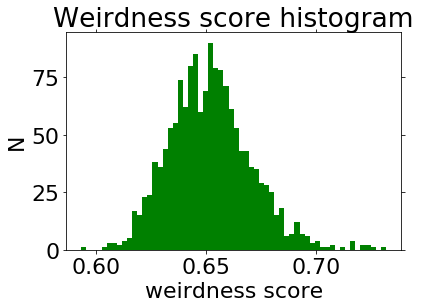

In [56]:
sum_vec = numpy.sum(dis_mat, axis=1)
sum_vec /= float(len(sum_vec))

plt.rcParams['figure.figsize'] = 6, 4
plt.title("Weirdness score histogram")
tmp = plt.hist(sum_vec, bins=60, color="g")
plt.ylabel("N")
plt.xlabel("weirdness score")

In [59]:
N_outliers = 10
sum_vec_outliers = numpy.sort(sum_vec)[::-1][:N_outliers]
obj_ids_outliers = obj_ids[numpy.argsort(sum_vec)][::-1][:N_outliers]

# plt.rcParams['figure.figsize'] = 10, 10
# plt.title("Data and outliers")
# plt.plot(TeffHs, loggHs, "ok", label="input daya", markersize=4)
# plt.plot(TeffHs[obj_ids_outliers], loggHs[obj_ids_outliers], "om", label="outliers", markersize=4)
# plt.xlabel("Feature 1")
# plt.ylabel("Feature 2")	
# plt.legend(loc="best")

In [60]:
candidates = list(wdtable['specnames'][obj_ids_outliers])
candidates = [i+'.fits' for i in candidates]

100%|██████████| 10/10 [00:00<00:00, 15.01it/s]


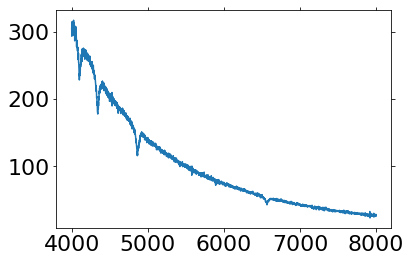

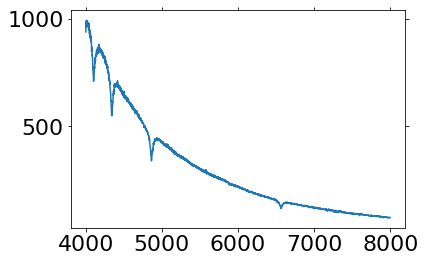

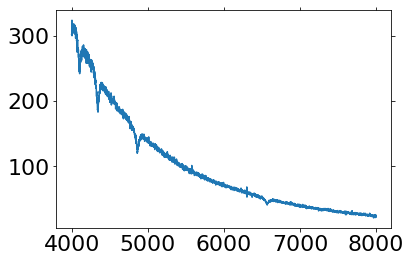

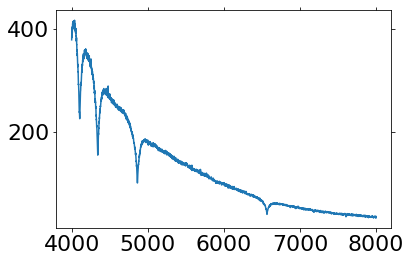

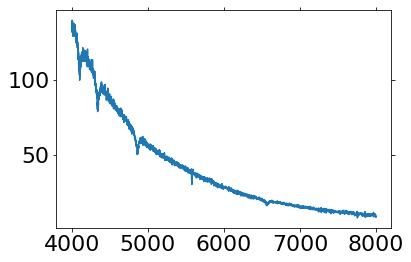

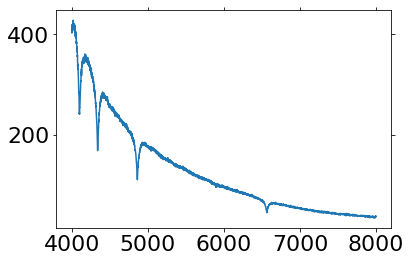

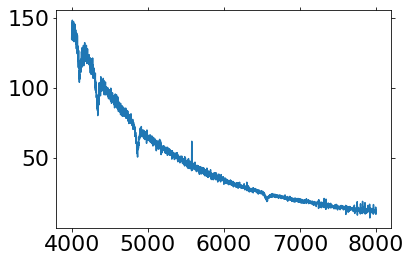

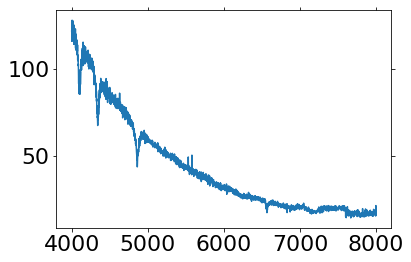

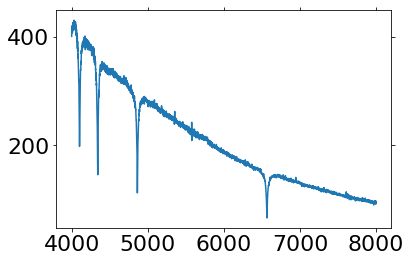

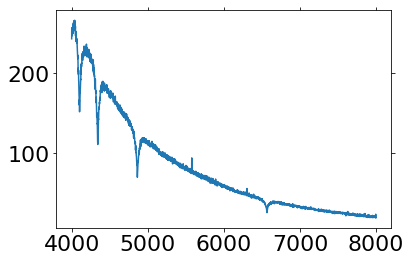

In [61]:
for specname in tqdm(candidates):
    f = fits.open(inputPath+specname)
    loglam = f[1].data['loglam']
    flux = f[1].data['flux']
    lam = 10**loglam
    lam = lam.astype(np.float64)
    flux = flux.astype(np.float64)
    lamgrid = np.arange(4000,8000)
    func = interp1d(lam,flux,kind='cubic',assume_sorted = False,fill_value='extrapolate')
    flux = func(lamgrid)
    plt.figure()
    plt.plot(lamgrid,flux)